In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 dydmderv


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-dydmderv:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                   | 1/685 [00:01<14:43,  1.29s/it]

  0%|▍                                                                                                                                                   | 2/685 [00:01<07:32,  1.51it/s]

  0%|▋                                                                                                                                                   | 3/685 [00:01<05:13,  2.17it/s]

  1%|▊                                                                                                                                                   | 4/685 [00:01<04:08,  2.74it/s]

  1%|█                                                                                                                                                   | 5/685 [00:02<03:32,  3.19it/s]

  1%|█▎                                                                                                                                                  | 6/685 [00:02<03:11,  3.55it/s]

  1%|█▌                                                                                                                                                  | 7/685 [00:02<02:57,  3.82it/s]

  1%|█▋                                                                                                                                                  | 8/685 [00:02<02:48,  4.03it/s]

  1%|█▉                                                                                                                                                  | 9/685 [00:03<02:41,  4.18it/s]

  1%|██▏                                                                                                                                                | 10/685 [00:03<02:37,  4.28it/s]

  2%|██▎                                                                                                                                                | 11/685 [00:03<02:34,  4.36it/s]

  2%|██▌                                                                                                                                                | 12/685 [00:03<02:32,  4.41it/s]

  2%|██▊                                                                                                                                                | 13/685 [00:03<02:30,  4.45it/s]

  2%|███                                                                                                                                                | 14/685 [00:04<02:29,  4.48it/s]

  2%|███▏                                                                                                                                               | 15/685 [00:04<02:28,  4.50it/s]

  2%|███▍                                                                                                                                               | 16/685 [00:04<02:28,  4.51it/s]

  2%|███▋                                                                                                                                               | 17/685 [00:04<02:27,  4.52it/s]

  3%|███▊                                                                                                                                               | 18/685 [00:05<02:27,  4.53it/s]

  3%|████                                                                                                                                               | 19/685 [00:05<02:26,  4.53it/s]

  3%|████▎                                                                                                                                              | 20/685 [00:05<02:26,  4.54it/s]

  3%|████▌                                                                                                                                              | 21/685 [00:05<02:26,  4.54it/s]

  3%|████▋                                                                                                                                              | 22/685 [00:05<02:26,  4.54it/s]

  3%|████▉                                                                                                                                              | 23/685 [00:06<02:25,  4.54it/s]

  4%|█████▏                                                                                                                                             | 24/685 [00:06<02:25,  4.54it/s]

  4%|█████▎                                                                                                                                             | 25/685 [00:06<02:25,  4.54it/s]

  4%|█████▌                                                                                                                                             | 26/685 [00:06<02:25,  4.54it/s]

  4%|█████▊                                                                                                                                             | 27/685 [00:07<02:24,  4.55it/s]

  4%|██████                                                                                                                                             | 28/685 [00:07<02:24,  4.54it/s]

  4%|██████▏                                                                                                                                            | 29/685 [00:07<02:24,  4.54it/s]

  4%|██████▍                                                                                                                                            | 30/685 [00:07<02:24,  4.54it/s]

  5%|██████▋                                                                                                                                            | 31/685 [00:07<02:23,  4.54it/s]

  5%|██████▊                                                                                                                                            | 32/685 [00:08<02:23,  4.54it/s]

  5%|███████                                                                                                                                            | 33/685 [00:08<02:23,  4.54it/s]

  5%|███████▎                                                                                                                                           | 34/685 [00:08<02:23,  4.54it/s]

  5%|███████▌                                                                                                                                           | 35/685 [00:08<02:23,  4.54it/s]

  5%|███████▋                                                                                                                                           | 36/685 [00:08<02:22,  4.54it/s]

  5%|███████▉                                                                                                                                           | 37/685 [00:09<02:22,  4.54it/s]

  6%|████████▏                                                                                                                                          | 38/685 [00:09<02:22,  4.55it/s]

  6%|████████▎                                                                                                                                          | 39/685 [00:09<02:22,  4.54it/s]

  6%|████████▌                                                                                                                                          | 40/685 [00:09<02:21,  4.54it/s]

  6%|████████▊                                                                                                                                          | 41/685 [00:10<02:21,  4.55it/s]

  6%|█████████                                                                                                                                          | 42/685 [00:10<02:21,  4.54it/s]

  6%|█████████▏                                                                                                                                         | 43/685 [00:10<02:21,  4.54it/s]

  6%|█████████▍                                                                                                                                         | 44/685 [00:10<02:21,  4.55it/s]

  7%|█████████▋                                                                                                                                         | 45/685 [00:10<02:20,  4.55it/s]

  7%|█████████▊                                                                                                                                         | 46/685 [00:11<02:20,  4.54it/s]

  7%|██████████                                                                                                                                         | 47/685 [00:11<02:20,  4.54it/s]

  7%|██████████▎                                                                                                                                        | 48/685 [00:11<02:20,  4.55it/s]

  7%|██████████▌                                                                                                                                        | 49/685 [00:11<02:20,  4.54it/s]

  7%|██████████▋                                                                                                                                        | 50/685 [00:12<02:19,  4.54it/s]

  7%|██████████▉                                                                                                                                        | 51/685 [00:12<02:19,  4.54it/s]

  8%|███████████▏                                                                                                                                       | 52/685 [00:12<02:19,  4.55it/s]

  8%|███████████▎                                                                                                                                       | 53/685 [00:12<02:19,  4.54it/s]

  8%|███████████▌                                                                                                                                       | 54/685 [00:12<02:18,  4.54it/s]

  8%|███████████▊                                                                                                                                       | 55/685 [00:13<02:18,  4.54it/s]

  8%|████████████                                                                                                                                       | 56/685 [00:13<02:18,  4.54it/s]

  8%|████████████▏                                                                                                                                      | 57/685 [00:13<02:18,  4.54it/s]

  8%|████████████▍                                                                                                                                      | 58/685 [00:13<02:18,  4.54it/s]

  9%|████████████▋                                                                                                                                      | 59/685 [00:14<02:17,  4.54it/s]

  9%|████████████▉                                                                                                                                      | 60/685 [00:14<02:17,  4.54it/s]

  9%|█████████████                                                                                                                                      | 61/685 [00:14<02:17,  4.54it/s]

  9%|█████████████▎                                                                                                                                     | 62/685 [00:14<02:17,  4.54it/s]

  9%|█████████████▌                                                                                                                                     | 63/685 [00:14<02:17,  4.54it/s]

  9%|█████████████▋                                                                                                                                     | 64/685 [00:15<02:16,  4.54it/s]

  9%|█████████████▉                                                                                                                                     | 65/685 [00:15<02:16,  4.54it/s]

 10%|██████████████▏                                                                                                                                    | 66/685 [00:15<02:16,  4.54it/s]

 10%|██████████████▍                                                                                                                                    | 67/685 [00:15<02:16,  4.54it/s]

 10%|██████████████▌                                                                                                                                    | 68/685 [00:16<02:15,  4.54it/s]

 10%|██████████████▊                                                                                                                                    | 69/685 [00:16<02:15,  4.54it/s]

 10%|███████████████                                                                                                                                    | 70/685 [00:16<02:15,  4.54it/s]

 10%|███████████████▏                                                                                                                                   | 71/685 [00:16<02:15,  4.54it/s]

 11%|███████████████▍                                                                                                                                   | 72/685 [00:16<02:14,  4.54it/s]

 11%|███████████████▋                                                                                                                                   | 73/685 [00:17<02:14,  4.54it/s]

 11%|███████████████▉                                                                                                                                   | 74/685 [00:17<02:14,  4.54it/s]

 11%|████████████████                                                                                                                                   | 75/685 [00:17<02:14,  4.54it/s]

 11%|████████████████▎                                                                                                                                  | 76/685 [00:17<02:14,  4.54it/s]

 11%|████████████████▌                                                                                                                                  | 77/685 [00:18<02:13,  4.54it/s]

 11%|████████████████▋                                                                                                                                  | 78/685 [00:18<02:13,  4.54it/s]

 12%|████████████████▉                                                                                                                                  | 79/685 [00:18<02:13,  4.54it/s]

 12%|█████████████████▏                                                                                                                                 | 80/685 [00:18<02:13,  4.54it/s]

 12%|█████████████████▍                                                                                                                                 | 81/685 [00:18<02:13,  4.54it/s]

 12%|█████████████████▌                                                                                                                                 | 82/685 [00:19<02:12,  4.54it/s]

 12%|█████████████████▊                                                                                                                                 | 83/685 [00:19<02:12,  4.54it/s]

 12%|██████████████████                                                                                                                                 | 84/685 [00:19<02:12,  4.54it/s]

 12%|██████████████████▏                                                                                                                                | 85/685 [00:19<02:12,  4.54it/s]

 13%|██████████████████▍                                                                                                                                | 86/685 [00:20<02:11,  4.54it/s]

 13%|██████████████████▋                                                                                                                                | 87/685 [00:20<02:11,  4.54it/s]

 13%|██████████████████▉                                                                                                                                | 88/685 [00:20<02:11,  4.54it/s]

 13%|███████████████████                                                                                                                                | 89/685 [00:20<02:11,  4.54it/s]

 13%|███████████████████▎                                                                                                                               | 90/685 [00:20<02:10,  4.55it/s]

 13%|███████████████████▌                                                                                                                               | 91/685 [00:21<02:10,  4.54it/s]

 13%|███████████████████▋                                                                                                                               | 92/685 [00:21<02:10,  4.55it/s]

 14%|███████████████████▉                                                                                                                               | 93/685 [00:21<02:10,  4.55it/s]

 14%|████████████████████▏                                                                                                                              | 94/685 [00:21<02:09,  4.55it/s]

 14%|████████████████████▍                                                                                                                              | 95/685 [00:21<02:09,  4.54it/s]

 14%|████████████████████▌                                                                                                                              | 96/685 [00:22<02:09,  4.55it/s]

 14%|████████████████████▊                                                                                                                              | 97/685 [00:22<02:09,  4.55it/s]

 14%|█████████████████████                                                                                                                              | 98/685 [00:22<02:09,  4.54it/s]

 14%|█████████████████████▏                                                                                                                             | 99/685 [00:22<02:08,  4.55it/s]

 15%|█████████████████████▎                                                                                                                            | 100/685 [00:23<02:08,  4.55it/s]

 15%|█████████████████████▌                                                                                                                            | 101/685 [00:23<02:08,  4.55it/s]

 15%|█████████████████████▋                                                                                                                            | 102/685 [00:23<02:08,  4.54it/s]

 15%|█████████████████████▉                                                                                                                            | 103/685 [00:23<02:08,  4.55it/s]

 15%|██████████████████████▏                                                                                                                           | 104/685 [00:23<02:07,  4.55it/s]

 15%|██████████████████████▍                                                                                                                           | 105/685 [00:24<02:07,  4.54it/s]

 15%|██████████████████████▌                                                                                                                           | 106/685 [00:24<02:07,  4.54it/s]

 16%|██████████████████████▊                                                                                                                           | 107/685 [00:24<02:07,  4.55it/s]

 16%|███████████████████████                                                                                                                           | 108/685 [00:24<02:06,  4.55it/s]

 16%|███████████████████████▏                                                                                                                          | 109/685 [00:25<02:06,  4.54it/s]

 16%|███████████████████████▍                                                                                                                          | 110/685 [00:25<02:06,  4.55it/s]

 16%|███████████████████████▋                                                                                                                          | 111/685 [00:25<02:06,  4.55it/s]

 16%|███████████████████████▊                                                                                                                          | 112/685 [00:25<02:06,  4.54it/s]

 16%|████████████████████████                                                                                                                          | 113/685 [00:25<02:05,  4.54it/s]

 17%|████████████████████████▎                                                                                                                         | 114/685 [00:26<02:05,  4.55it/s]

 17%|████████████████████████▌                                                                                                                         | 115/685 [00:26<02:05,  4.55it/s]

 17%|████████████████████████▋                                                                                                                         | 116/685 [00:26<02:05,  4.54it/s]

 17%|████████████████████████▉                                                                                                                         | 117/685 [00:26<02:04,  4.55it/s]

 17%|█████████████████████████▏                                                                                                                        | 118/685 [00:27<02:04,  4.55it/s]

 17%|█████████████████████████▎                                                                                                                        | 119/685 [00:27<02:04,  4.54it/s]

 18%|█████████████████████████▌                                                                                                                        | 120/685 [00:27<02:04,  4.54it/s]

 18%|█████████████████████████▊                                                                                                                        | 121/685 [00:27<02:04,  4.55it/s]

 18%|██████████████████████████                                                                                                                        | 122/685 [00:27<02:03,  4.55it/s]

 18%|██████████████████████████▏                                                                                                                       | 123/685 [00:28<02:03,  4.54it/s]

 18%|██████████████████████████▍                                                                                                                       | 124/685 [00:28<02:03,  4.55it/s]

 18%|██████████████████████████▋                                                                                                                       | 125/685 [00:28<02:03,  4.55it/s]

 18%|██████████████████████████▊                                                                                                                       | 126/685 [00:28<02:03,  4.54it/s]

 19%|███████████████████████████                                                                                                                       | 127/685 [00:29<02:02,  4.55it/s]

 19%|███████████████████████████▎                                                                                                                      | 128/685 [00:29<02:02,  4.55it/s]

 19%|███████████████████████████▍                                                                                                                      | 129/685 [00:29<02:02,  4.55it/s]

 19%|███████████████████████████▋                                                                                                                      | 130/685 [00:29<02:02,  4.55it/s]

 19%|███████████████████████████▉                                                                                                                      | 131/685 [00:29<02:01,  4.55it/s]

 19%|████████████████████████████▏                                                                                                                     | 132/685 [00:30<02:01,  4.55it/s]

 19%|████████████████████████████▎                                                                                                                     | 133/685 [00:30<02:01,  4.54it/s]

 20%|████████████████████████████▌                                                                                                                     | 134/685 [00:30<02:01,  4.55it/s]

 20%|████████████████████████████▊                                                                                                                     | 135/685 [00:30<02:00,  4.55it/s]

 20%|████████████████████████████▉                                                                                                                     | 136/685 [00:31<02:00,  4.55it/s]

 20%|█████████████████████████████▏                                                                                                                    | 137/685 [00:31<02:00,  4.54it/s]

 20%|█████████████████████████████▍                                                                                                                    | 138/685 [00:31<02:00,  4.55it/s]

 20%|█████████████████████████████▋                                                                                                                    | 139/685 [00:31<02:00,  4.55it/s]

 20%|█████████████████████████████▊                                                                                                                    | 140/685 [00:31<01:59,  4.54it/s]

 21%|██████████████████████████████                                                                                                                    | 141/685 [00:32<01:59,  4.54it/s]

 21%|██████████████████████████████▎                                                                                                                   | 142/685 [00:32<01:59,  4.55it/s]

 21%|██████████████████████████████▍                                                                                                                   | 143/685 [00:32<01:59,  4.55it/s]

 21%|██████████████████████████████▋                                                                                                                   | 144/685 [00:32<01:59,  4.54it/s]

 21%|██████████████████████████████▉                                                                                                                   | 145/685 [00:32<01:58,  4.55it/s]

 21%|███████████████████████████████                                                                                                                   | 146/685 [00:33<01:58,  4.55it/s]

 21%|███████████████████████████████▎                                                                                                                  | 147/685 [00:33<01:58,  4.54it/s]

 22%|███████████████████████████████▌                                                                                                                  | 148/685 [00:33<01:58,  4.55it/s]

 22%|███████████████████████████████▊                                                                                                                  | 149/685 [00:33<01:57,  4.55it/s]

 22%|███████████████████████████████▉                                                                                                                  | 150/685 [00:34<01:57,  4.55it/s]

 22%|████████████████████████████████▏                                                                                                                 | 151/685 [00:34<01:57,  4.54it/s]

 22%|████████████████████████████████▍                                                                                                                 | 152/685 [00:34<01:57,  4.55it/s]

 22%|████████████████████████████████▌                                                                                                                 | 153/685 [00:34<01:57,  4.55it/s]

 22%|████████████████████████████████▊                                                                                                                 | 154/685 [00:34<01:56,  4.54it/s]

 23%|█████████████████████████████████                                                                                                                 | 155/685 [00:35<01:56,  4.54it/s]

 23%|█████████████████████████████████▏                                                                                                                | 156/685 [00:35<01:56,  4.55it/s]

 23%|█████████████████████████████████▍                                                                                                                | 157/685 [00:35<01:56,  4.55it/s]

 23%|█████████████████████████████████▋                                                                                                                | 158/685 [00:35<01:55,  4.54it/s]

 23%|█████████████████████████████████▉                                                                                                                | 159/685 [00:36<01:55,  4.55it/s]

 23%|██████████████████████████████████                                                                                                                | 160/685 [00:36<01:55,  4.55it/s]

 24%|██████████████████████████████████▎                                                                                                               | 161/685 [00:36<01:55,  4.54it/s]

 24%|██████████████████████████████████▌                                                                                                               | 162/685 [00:36<01:55,  4.55it/s]

 24%|██████████████████████████████████▋                                                                                                               | 163/685 [00:36<01:54,  4.55it/s]

 24%|██████████████████████████████████▉                                                                                                               | 164/685 [00:37<01:54,  4.55it/s]

 24%|███████████████████████████████████▏                                                                                                              | 165/685 [00:37<01:54,  4.54it/s]

 24%|███████████████████████████████████▍                                                                                                              | 166/685 [00:37<01:54,  4.55it/s]

 24%|███████████████████████████████████▌                                                                                                              | 167/685 [00:37<01:53,  4.55it/s]

 25%|███████████████████████████████████▊                                                                                                              | 168/685 [00:38<01:53,  4.55it/s]

 25%|████████████████████████████████████                                                                                                              | 169/685 [00:38<01:53,  4.55it/s]

 25%|████████████████████████████████████▏                                                                                                             | 170/685 [00:38<01:53,  4.55it/s]

 25%|████████████████████████████████████▍                                                                                                             | 171/685 [00:38<01:53,  4.55it/s]

 25%|████████████████████████████████████▋                                                                                                             | 172/685 [00:38<01:52,  4.54it/s]

 25%|████████████████████████████████████▊                                                                                                             | 173/685 [00:39<01:52,  4.55it/s]

 25%|█████████████████████████████████████                                                                                                             | 174/685 [00:39<01:52,  4.55it/s]

 26%|█████████████████████████████████████▎                                                                                                            | 175/685 [00:39<01:52,  4.54it/s]

 26%|█████████████████████████████████████▌                                                                                                            | 176/685 [00:39<01:52,  4.54it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 177/685 [00:40<01:51,  4.55it/s]

 26%|█████████████████████████████████████▉                                                                                                            | 178/685 [00:40<01:51,  4.55it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 179/685 [00:40<01:51,  4.54it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 180/685 [00:40<01:51,  4.55it/s]

 26%|██████████████████████████████████████▌                                                                                                           | 181/685 [00:40<01:50,  4.55it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 182/685 [00:41<01:50,  4.54it/s]

 27%|███████████████████████████████████████                                                                                                           | 183/685 [00:41<01:50,  4.55it/s]

 27%|███████████████████████████████████████▏                                                                                                          | 184/685 [00:41<01:50,  4.55it/s]

 27%|███████████████████████████████████████▍                                                                                                          | 185/685 [00:41<01:49,  4.55it/s]

 27%|███████████████████████████████████████▋                                                                                                          | 186/685 [00:42<01:49,  4.54it/s]

 27%|███████████████████████████████████████▊                                                                                                          | 187/685 [00:42<01:49,  4.55it/s]

 27%|████████████████████████████████████████                                                                                                          | 188/685 [00:42<01:48,  4.56it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 189/685 [00:42<01:48,  4.57it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 190/685 [00:42<01:48,  4.58it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 191/685 [00:43<01:47,  4.58it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 192/685 [00:43<01:47,  4.58it/s]

 28%|█████████████████████████████████████████▏                                                                                                        | 193/685 [00:43<01:47,  4.58it/s]

 28%|█████████████████████████████████████████▎                                                                                                        | 194/685 [00:43<01:47,  4.58it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 195/685 [00:43<01:46,  4.59it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 196/685 [00:44<01:46,  4.58it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 197/685 [00:44<01:46,  4.59it/s]

 29%|██████████████████████████████████████████▏                                                                                                       | 198/685 [00:44<01:46,  4.59it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 199/685 [00:44<01:45,  4.59it/s]

 29%|██████████████████████████████████████████▋                                                                                                       | 200/685 [00:45<01:45,  4.59it/s]

 29%|██████████████████████████████████████████▊                                                                                                       | 201/685 [00:45<01:45,  4.59it/s]

 29%|███████████████████████████████████████████                                                                                                       | 202/685 [00:45<01:45,  4.59it/s]

 30%|███████████████████████████████████████████▎                                                                                                      | 203/685 [00:45<01:45,  4.59it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 204/685 [00:45<01:44,  4.59it/s]

 30%|███████████████████████████████████████████▋                                                                                                      | 205/685 [00:46<01:44,  4.59it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 206/685 [00:46<01:44,  4.59it/s]

 30%|████████████████████████████████████████████                                                                                                      | 207/685 [00:46<01:44,  4.59it/s]

 30%|████████████████████████████████████████████▎                                                                                                     | 208/685 [00:46<01:43,  4.59it/s]

 31%|████████████████████████████████████████████▌                                                                                                     | 209/685 [00:47<01:43,  4.59it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 210/685 [00:47<01:43,  4.59it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 211/685 [00:47<01:43,  4.59it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 212/685 [00:47<01:43,  4.59it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 213/685 [00:47<01:42,  4.59it/s]

 31%|█████████████████████████████████████████████▌                                                                                                    | 214/685 [00:48<01:42,  4.59it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 215/685 [00:48<01:42,  4.59it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 216/685 [00:48<01:42,  4.59it/s]

 32%|██████████████████████████████████████████████▎                                                                                                   | 217/685 [00:48<01:42,  4.59it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 218/685 [00:48<01:41,  4.59it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 219/685 [00:49<01:41,  4.59it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 220/685 [00:49<01:41,  4.59it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 221/685 [00:49<01:41,  4.59it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 222/685 [00:49<01:40,  4.59it/s]

 33%|███████████████████████████████████████████████▌                                                                                                  | 223/685 [00:50<01:40,  4.59it/s]

 33%|███████████████████████████████████████████████▋                                                                                                  | 224/685 [00:50<01:40,  4.59it/s]

 33%|███████████████████████████████████████████████▉                                                                                                  | 225/685 [00:50<01:40,  4.59it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 226/685 [00:50<01:39,  4.59it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 227/685 [00:50<01:39,  4.59it/s]

 33%|████████████████████████████████████████████████▌                                                                                                 | 228/685 [00:51<01:39,  4.59it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 229/685 [00:51<01:39,  4.59it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 230/685 [00:51<01:39,  4.59it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 231/685 [00:51<01:38,  4.59it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 232/685 [00:52<01:38,  4.59it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 233/685 [00:52<01:38,  4.59it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 234/685 [00:52<01:38,  4.59it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 235/685 [00:52<01:38,  4.59it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 236/685 [00:52<01:37,  4.59it/s]

 35%|██████████████████████████████████████████████████▌                                                                                               | 237/685 [00:53<01:37,  4.59it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 238/685 [00:53<01:37,  4.59it/s]

 35%|██████████████████████████████████████████████████▉                                                                                               | 239/685 [00:53<01:37,  4.59it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 240/685 [00:53<01:36,  4.59it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 241/685 [00:53<01:36,  4.59it/s]

 35%|███████████████████████████████████████████████████▌                                                                                              | 242/685 [00:54<01:36,  4.59it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 243/685 [00:54<01:36,  4.59it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 244/685 [00:54<01:36,  4.59it/s]

 36%|████████████████████████████████████████████████████▏                                                                                             | 245/685 [00:54<01:35,  4.59it/s]

 36%|████████████████████████████████████████████████████▍                                                                                             | 246/685 [00:55<01:35,  4.59it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 247/685 [00:55<01:35,  4.59it/s]

 36%|████████████████████████████████████████████████████▊                                                                                             | 248/685 [00:55<01:35,  4.59it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 249/685 [00:55<01:35,  4.59it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                            | 250/685 [00:55<01:34,  4.59it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 251/685 [00:56<01:34,  4.59it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 252/685 [00:56<01:34,  4.59it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                            | 253/685 [00:56<01:34,  4.59it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                           | 254/685 [00:56<01:33,  4.59it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 255/685 [00:57<01:33,  4.59it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 256/685 [00:57<01:33,  4.59it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 257/685 [00:57<01:33,  4.59it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                           | 258/685 [00:57<01:33,  4.59it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 259/685 [00:57<01:32,  4.59it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 260/685 [00:58<01:32,  4.59it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 261/685 [00:58<01:32,  4.59it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                          | 262/685 [00:58<01:32,  4.59it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 263/685 [00:58<01:31,  4.59it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                         | 264/685 [00:59<01:31,  4.59it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 265/685 [00:59<01:31,  4.59it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 266/685 [00:59<01:31,  4.59it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                         | 267/685 [00:59<01:31,  4.59it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 268/685 [00:59<01:30,  4.59it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 269/685 [01:00<01:30,  4.59it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 270/685 [01:00<01:30,  4.59it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 271/685 [01:00<01:30,  4.59it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                        | 272/685 [01:00<01:29,  4.59it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 273/685 [01:00<01:29,  4.59it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 274/685 [01:01<01:29,  4.59it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                       | 275/685 [01:01<01:29,  4.59it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 276/685 [01:01<01:29,  4.59it/s]

 40%|███████████████████████████████████████████████████████████                                                                                       | 277/685 [01:01<01:28,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                      | 278/685 [01:02<01:28,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 279/685 [01:02<01:28,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 280/685 [01:02<01:28,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 281/685 [01:02<01:28,  4.59it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 282/685 [01:02<01:27,  4.59it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                     | 283/685 [01:03<01:27,  4.59it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 284/685 [01:03<01:27,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 285/685 [01:03<01:27,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 286/685 [01:03<01:26,  4.59it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 287/685 [01:04<01:26,  4.59it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 288/685 [01:04<01:26,  4.59it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                    | 289/685 [01:04<01:26,  4.59it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 290/685 [01:04<01:26,  4.59it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                    | 291/685 [01:04<01:25,  4.59it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 292/685 [01:05<01:25,  4.59it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 293/685 [01:05<01:25,  4.59it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 294/685 [01:05<01:25,  4.59it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 295/685 [01:05<01:24,  4.59it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                   | 296/685 [01:05<01:24,  4.59it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 297/685 [01:06<01:24,  4.59it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                  | 298/685 [01:06<01:24,  4.59it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 299/685 [01:06<01:24,  4.59it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 300/685 [01:06<01:23,  4.59it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 301/685 [01:07<01:23,  4.59it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                 | 302/685 [01:07<01:23,  4.59it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 303/685 [01:07<01:23,  4.59it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 304/685 [01:07<01:23,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                 | 305/685 [01:07<01:22,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 306/685 [01:08<01:22,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 307/685 [01:08<01:22,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 308/685 [01:08<01:22,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 309/685 [01:08<01:21,  4.59it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 310/685 [01:09<01:21,  4.59it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 311/685 [01:09<01:21,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                               | 312/685 [01:09<01:21,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                               | 313/685 [01:09<01:21,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                               | 314/685 [01:09<01:20,  4.59it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 315/685 [01:10<01:20,  4.59it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                              | 316/685 [01:10<01:20,  4.59it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                              | 317/685 [01:10<01:20,  4.59it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 318/685 [01:10<01:19,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                              | 319/685 [01:10<01:19,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 320/685 [01:11<01:19,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 321/685 [01:11<01:19,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                             | 322/685 [01:11<01:19,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 323/685 [01:11<01:18,  4.59it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                             | 324/685 [01:12<01:18,  4.59it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 325/685 [01:12<01:18,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 326/685 [01:12<01:18,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                            | 327/685 [01:12<01:18,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 328/685 [01:12<01:17,  4.59it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                            | 329/685 [01:13<01:17,  4.59it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 330/685 [01:13<01:17,  4.59it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 331/685 [01:13<01:17,  4.59it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                           | 332/685 [01:13<01:16,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 333/685 [01:14<01:16,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 334/685 [01:14<01:16,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 335/685 [01:14<01:16,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 336/685 [01:14<01:16,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 337/685 [01:14<01:15,  4.59it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 338/685 [01:15<01:15,  4.59it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                         | 339/685 [01:15<01:15,  4.59it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 340/685 [01:15<01:15,  4.59it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 341/685 [01:15<01:14,  4.59it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                         | 342/685 [01:15<01:14,  4.59it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 343/685 [01:16<01:14,  4.59it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                        | 344/685 [01:16<01:14,  4.59it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 345/685 [01:16<01:14,  4.59it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 346/685 [01:16<01:13,  4.59it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 347/685 [01:17<01:13,  4.59it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 348/685 [01:17<01:13,  4.59it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 349/685 [01:17<01:13,  4.59it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 350/685 [01:17<01:12,  4.59it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 351/685 [01:17<01:12,  4.59it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                       | 352/685 [01:18<01:12,  4.59it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 353/685 [01:18<01:12,  4.59it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                      | 354/685 [01:18<01:12,  4.59it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 355/685 [01:18<01:11,  4.59it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 356/685 [01:19<01:11,  4.59it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 357/685 [01:19<01:11,  4.59it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                     | 358/685 [01:19<01:11,  4.59it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 359/685 [01:19<01:11,  4.59it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 360/685 [01:19<01:10,  4.59it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 361/685 [01:20<01:10,  4.59it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 362/685 [01:20<01:10,  4.59it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                    | 363/685 [01:20<01:10,  4.59it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 364/685 [01:20<01:09,  4.59it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 365/685 [01:21<01:09,  4.59it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                    | 366/685 [01:21<01:09,  4.59it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                   | 367/685 [01:21<01:09,  4.59it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                   | 368/685 [01:21<01:09,  4.59it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                   | 369/685 [01:21<01:08,  4.59it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 370/685 [01:22<01:08,  4.59it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                   | 371/685 [01:22<01:08,  4.59it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                  | 372/685 [01:22<01:08,  4.59it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 373/685 [01:22<01:07,  4.59it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 374/685 [01:22<01:07,  4.59it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                  | 375/685 [01:23<01:07,  4.59it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 376/685 [01:23<01:07,  4.58it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 377/685 [01:23<01:07,  4.59it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 378/685 [01:23<01:06,  4.59it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                 | 379/685 [01:24<01:06,  4.59it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 380/685 [01:24<01:06,  4.59it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 381/685 [01:24<01:06,  4.59it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 382/685 [01:24<01:06,  4.59it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                | 383/685 [01:24<01:05,  4.59it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 384/685 [01:25<01:05,  4.59it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 385/685 [01:25<01:05,  4.59it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 386/685 [01:25<01:05,  4.59it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                               | 387/685 [01:25<01:04,  4.59it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 388/685 [01:26<01:04,  4.59it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 389/685 [01:26<01:04,  4.59it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                               | 390/685 [01:26<01:04,  4.59it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 391/685 [01:26<01:04,  4.59it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 392/685 [01:26<01:03,  4.59it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 393/685 [01:27<01:03,  4.59it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 394/685 [01:27<01:03,  4.59it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 395/685 [01:27<01:03,  4.59it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 396/685 [01:27<01:02,  4.59it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 397/685 [01:27<01:02,  4.59it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 398/685 [01:28<01:02,  4.59it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 399/685 [01:28<01:02,  4.59it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 400/685 [01:28<01:02,  4.59it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 401/685 [01:28<01:01,  4.59it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                            | 402/685 [01:29<01:01,  4.59it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                            | 403/685 [01:29<01:01,  4.59it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 404/685 [01:29<01:01,  4.59it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/685 [01:29<01:00,  4.59it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 406/685 [01:29<01:00,  4.59it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 407/685 [01:30<01:00,  4.59it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                           | 408/685 [01:30<01:00,  4.59it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 409/685 [01:30<01:00,  4.59it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                          | 410/685 [01:30<00:59,  4.59it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 411/685 [01:31<00:59,  4.59it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                          | 412/685 [01:31<00:59,  4.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 413/685 [01:31<00:59,  4.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 414/685 [01:31<00:59,  4.59it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 415/685 [01:31<00:58,  4.59it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 416/685 [01:32<00:58,  4.59it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 417/685 [01:32<00:58,  4.59it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 418/685 [01:32<00:58,  4.59it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 419/685 [01:32<00:57,  4.59it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 420/685 [01:32<00:57,  4.59it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 421/685 [01:33<00:57,  4.59it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 422/685 [01:33<00:57,  4.59it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 423/685 [01:33<00:57,  4.59it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 424/685 [01:33<00:56,  4.59it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 425/685 [01:34<00:56,  4.59it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 426/685 [01:34<00:56,  4.59it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                       | 427/685 [01:34<00:56,  4.59it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 428/685 [01:34<00:55,  4.59it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 429/685 [01:34<00:55,  4.59it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 430/685 [01:35<00:55,  4.59it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 431/685 [01:35<00:55,  4.59it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                      | 432/685 [01:35<00:55,  4.59it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 433/685 [01:35<00:54,  4.59it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 434/685 [01:36<00:54,  4.59it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 435/685 [01:36<00:54,  4.59it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 436/685 [01:36<00:54,  4.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 437/685 [01:36<00:54,  4.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 438/685 [01:36<00:53,  4.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 439/685 [01:37<00:53,  4.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 440/685 [01:37<00:53,  4.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 441/685 [01:37<00:53,  4.59it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 442/685 [01:37<00:52,  4.59it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 443/685 [01:38<00:52,  4.59it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 444/685 [01:38<00:52,  4.59it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 445/685 [01:38<00:52,  4.59it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 446/685 [01:38<00:52,  4.59it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 447/685 [01:38<00:51,  4.59it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 448/685 [01:39<00:51,  4.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 449/685 [01:39<00:51,  4.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 450/685 [01:39<00:51,  4.59it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 451/685 [01:39<00:50,  4.59it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 452/685 [01:39<00:50,  4.59it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 453/685 [01:40<00:50,  4.59it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 454/685 [01:40<00:50,  4.59it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 455/685 [01:40<00:50,  4.59it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 456/685 [01:40<00:49,  4.59it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 457/685 [01:41<00:49,  4.59it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 458/685 [01:41<00:49,  4.59it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 459/685 [01:41<00:49,  4.59it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                | 460/685 [01:41<00:49,  4.59it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 461/685 [01:41<00:48,  4.59it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 462/685 [01:42<00:48,  4.59it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 463/685 [01:42<00:48,  4.59it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 464/685 [01:42<00:48,  4.59it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                               | 465/685 [01:42<00:47,  4.59it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 466/685 [01:43<00:47,  4.59it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 467/685 [01:43<00:47,  4.59it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 468/685 [01:43<00:47,  4.59it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 469/685 [01:43<00:47,  4.59it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 470/685 [01:43<00:46,  4.59it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 471/685 [01:44<00:46,  4.59it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 472/685 [01:44<00:46,  4.59it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 473/685 [01:44<00:46,  4.59it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 474/685 [01:44<00:45,  4.59it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 475/685 [01:44<00:45,  4.59it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 476/685 [01:45<00:45,  4.59it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 477/685 [01:45<00:45,  4.59it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 478/685 [01:45<00:45,  4.59it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 479/685 [01:45<00:44,  4.59it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 480/685 [01:46<00:44,  4.59it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 481/685 [01:46<00:44,  4.59it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 482/685 [01:46<00:44,  4.59it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 483/685 [01:46<00:43,  4.59it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 484/685 [01:46<00:43,  4.59it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 485/685 [01:47<00:43,  4.59it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 486/685 [01:47<00:43,  4.59it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 487/685 [01:47<00:43,  4.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 488/685 [01:47<00:42,  4.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 489/685 [01:48<00:42,  4.59it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 490/685 [01:48<00:42,  4.59it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 491/685 [01:48<00:42,  4.59it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 492/685 [01:48<00:42,  4.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 493/685 [01:48<00:41,  4.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 494/685 [01:49<00:41,  4.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 495/685 [01:49<00:41,  4.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 496/685 [01:49<00:41,  4.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 497/685 [01:49<00:40,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 498/685 [01:49<00:40,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 499/685 [01:50<00:40,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 500/685 [01:50<00:40,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 501/685 [01:50<00:40,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 502/685 [01:50<00:39,  4.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 503/685 [01:51<00:39,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 504/685 [01:51<00:39,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 505/685 [01:51<00:39,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 506/685 [01:51<00:38,  4.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 507/685 [01:51<00:38,  4.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 508/685 [01:52<00:38,  4.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 509/685 [01:52<00:38,  4.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 510/685 [01:52<00:38,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 511/685 [01:52<00:38,  4.56it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 512/685 [01:53<00:37,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 513/685 [01:53<00:37,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 514/685 [01:53<00:37,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 515/685 [01:53<00:37,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 516/685 [01:53<00:37,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 517/685 [01:54<00:36,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 518/685 [01:54<00:36,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 519/685 [01:54<00:36,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 520/685 [01:54<00:36,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 521/685 [01:55<00:36,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 522/685 [01:55<00:35,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 523/685 [01:55<00:35,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 524/685 [01:55<00:35,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 525/685 [01:55<00:35,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 526/685 [01:56<00:34,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 527/685 [01:56<00:34,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 528/685 [01:56<00:34,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 529/685 [01:56<00:34,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 530/685 [01:57<00:34,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 531/685 [01:57<00:33,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 532/685 [01:57<00:33,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 533/685 [01:57<00:33,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 534/685 [01:57<00:33,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 535/685 [01:58<00:32,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 536/685 [01:58<00:32,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 537/685 [01:58<00:32,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 538/685 [01:58<00:32,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 539/685 [01:58<00:32,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 540/685 [01:59<00:31,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 541/685 [01:59<00:31,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 542/685 [01:59<00:31,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 543/685 [01:59<00:31,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 544/685 [02:00<00:31,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 545/685 [02:00<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 546/685 [02:00<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 547/685 [02:00<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 548/685 [02:00<00:30,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 549/685 [02:01<00:29,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 550/685 [02:01<00:29,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 551/685 [02:01<00:29,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 552/685 [02:01<00:29,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 553/685 [02:02<00:29,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 554/685 [02:02<00:28,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 555/685 [02:02<00:28,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 556/685 [02:02<00:28,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 557/685 [02:02<00:28,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 558/685 [02:03<00:27,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 559/685 [02:03<00:27,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 560/685 [02:03<00:27,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 561/685 [02:03<00:27,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 562/685 [02:04<00:27,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 563/685 [02:04<00:26,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 564/685 [02:04<00:26,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 565/685 [02:04<00:26,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 566/685 [02:04<00:26,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 567/685 [02:05<00:25,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 568/685 [02:05<00:25,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 569/685 [02:05<00:25,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 570/685 [02:05<00:25,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 571/685 [02:06<00:25,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 572/685 [02:06<00:24,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 573/685 [02:06<00:24,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 574/685 [02:06<00:24,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 575/685 [02:06<00:24,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 576/685 [02:07<00:23,  4.56it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 577/685 [02:07<00:23,  4.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 578/685 [02:07<00:23,  4.57it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 579/685 [02:07<00:23,  4.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 580/685 [02:07<00:22,  4.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 581/685 [02:08<00:22,  4.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 582/685 [02:08<00:22,  4.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 583/685 [02:08<00:22,  4.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 584/685 [02:08<00:22,  4.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 585/685 [02:09<00:21,  4.58it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 586/685 [02:09<00:21,  4.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 587/685 [02:09<00:21,  4.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 588/685 [02:09<00:21,  4.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 589/685 [02:09<00:20,  4.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 590/685 [02:10<00:20,  4.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 591/685 [02:10<00:20,  4.59it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 592/685 [02:10<00:20,  4.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 593/685 [02:10<00:20,  4.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 594/685 [02:11<00:19,  4.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 595/685 [02:11<00:19,  4.59it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 596/685 [02:11<00:19,  4.59it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 597/685 [02:11<00:19,  4.59it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 598/685 [02:11<00:18,  4.59it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 599/685 [02:12<00:18,  4.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 600/685 [02:12<00:18,  4.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 601/685 [02:12<00:18,  4.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 602/685 [02:12<00:18,  4.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 603/685 [02:13<00:17,  4.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 604/685 [02:13<00:17,  4.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 605/685 [02:13<00:17,  4.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 606/685 [02:13<00:17,  4.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 607/685 [02:13<00:17,  4.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 608/685 [02:14<00:16,  4.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 609/685 [02:14<00:16,  4.59it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 610/685 [02:14<00:16,  4.59it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 611/685 [02:14<00:16,  4.45it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 612/685 [02:14<00:16,  4.49it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 613/685 [02:15<00:15,  4.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 614/685 [02:15<00:15,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 615/685 [02:15<00:15,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 616/685 [02:15<00:15,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 617/685 [02:16<00:14,  4.57it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 618/685 [02:16<00:14,  4.57it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 619/685 [02:16<00:14,  4.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 620/685 [02:16<00:14,  4.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 621/685 [02:16<00:13,  4.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 622/685 [02:17<00:13,  4.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 623/685 [02:17<00:13,  4.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 624/685 [02:17<00:13,  4.58it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 625/685 [02:17<00:13,  4.58it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 626/685 [02:18<00:12,  4.59it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 627/685 [02:18<00:12,  4.59it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 628/685 [02:18<00:12,  4.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 629/685 [02:18<00:12,  4.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 630/685 [02:18<00:11,  4.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 631/685 [02:19<00:11,  4.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 632/685 [02:19<00:11,  4.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 633/685 [02:19<00:11,  4.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 634/685 [02:19<00:11,  4.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 635/685 [02:20<00:10,  4.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 636/685 [02:20<00:10,  4.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 637/685 [02:20<00:10,  4.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 638/685 [02:20<00:10,  4.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 639/685 [02:20<00:10,  4.59it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 640/685 [02:21<00:09,  4.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 641/685 [02:21<00:09,  4.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 642/685 [02:21<00:09,  4.59it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 643/685 [02:21<00:09,  4.59it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 644/685 [02:21<00:08,  4.59it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 645/685 [02:22<00:08,  4.59it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 646/685 [02:22<00:08,  4.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 647/685 [02:22<00:08,  4.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 648/685 [02:22<00:08,  4.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 649/685 [02:23<00:07,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 650/685 [02:23<00:07,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 651/685 [02:23<00:07,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 652/685 [02:23<00:07,  4.59it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 653/685 [02:23<00:06,  4.59it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 654/685 [02:24<00:06,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 655/685 [02:24<00:06,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 656/685 [02:24<00:06,  4.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 657/685 [02:24<00:06,  4.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 658/685 [02:25<00:05,  4.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 659/685 [02:25<00:05,  4.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 660/685 [02:25<00:05,  4.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 661/685 [02:25<00:05,  4.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 662/685 [02:25<00:05,  4.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 663/685 [02:26<00:04,  4.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 664/685 [02:26<00:04,  4.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 665/685 [02:26<00:04,  4.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 666/685 [02:26<00:04,  4.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 667/685 [02:26<00:03,  4.59it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 668/685 [02:27<00:03,  4.59it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 669/685 [02:27<00:03,  4.58it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 670/685 [02:27<00:03,  4.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 671/685 [02:27<00:03,  4.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 672/685 [02:28<00:02,  4.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 673/685 [02:28<00:02,  4.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 674/685 [02:28<00:02,  4.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 675/685 [02:28<00:02,  4.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 676/685 [02:28<00:01,  4.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 677/685 [02:29<00:01,  4.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 678/685 [02:29<00:01,  4.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 679/685 [02:29<00:01,  4.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 680/685 [02:29<00:01,  4.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 681/685 [02:30<00:00,  4.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 682/685 [02:30<00:00,  4.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 683/685 [02:30<00:00,  4.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 684/685 [02:30<00:00,  4.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:30<00:00,  5.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:30<00:00,  4.54it/s]

train - OK


  0%|                                                                                                                                                            | 0/172 [00:00<?, ?it/s]

  1%|▊                                                                                                                                                   | 1/172 [00:00<00:58,  2.91it/s]

  1%|█▋                                                                                                                                                  | 2/172 [00:00<00:46,  3.69it/s]

  2%|██▌                                                                                                                                                 | 3/172 [00:00<00:41,  4.05it/s]

  2%|███▍                                                                                                                                                | 4/172 [00:01<00:39,  4.24it/s]

  3%|████▎                                                                                                                                               | 5/172 [00:01<00:38,  4.36it/s]

  3%|█████▏                                                                                                                                              | 6/172 [00:01<00:37,  4.43it/s]

  4%|██████                                                                                                                                              | 7/172 [00:01<00:36,  4.48it/s]

  5%|██████▉                                                                                                                                             | 8/172 [00:01<00:36,  4.51it/s]

  5%|███████▋                                                                                                                                            | 9/172 [00:02<00:35,  4.53it/s]

  6%|████████▌                                                                                                                                          | 10/172 [00:02<00:35,  4.54it/s]

  6%|█████████▍                                                                                                                                         | 11/172 [00:02<00:35,  4.55it/s]

  7%|██████████▎                                                                                                                                        | 12/172 [00:02<00:35,  4.56it/s]

  8%|███████████                                                                                                                                        | 13/172 [00:02<00:34,  4.57it/s]

  8%|███████████▉                                                                                                                                       | 14/172 [00:03<00:34,  4.57it/s]

  9%|████████████▊                                                                                                                                      | 15/172 [00:03<00:34,  4.57it/s]

  9%|█████████████▋                                                                                                                                     | 16/172 [00:03<00:34,  4.57it/s]

 10%|██████████████▌                                                                                                                                    | 17/172 [00:03<00:33,  4.58it/s]

 10%|███████████████▍                                                                                                                                   | 18/172 [00:04<00:33,  4.58it/s]

 11%|████████████████▏                                                                                                                                  | 19/172 [00:04<00:33,  4.58it/s]

 12%|█████████████████                                                                                                                                  | 20/172 [00:04<00:33,  4.58it/s]

 12%|█████████████████▉                                                                                                                                 | 21/172 [00:04<00:32,  4.58it/s]

 13%|██████████████████▊                                                                                                                                | 22/172 [00:04<00:32,  4.58it/s]

 13%|███████████████████▋                                                                                                                               | 23/172 [00:05<00:32,  4.58it/s]

 14%|████████████████████▌                                                                                                                              | 24/172 [00:05<00:32,  4.58it/s]

 15%|█████████████████████▎                                                                                                                             | 25/172 [00:05<00:32,  4.58it/s]

 15%|██████████████████████▏                                                                                                                            | 26/172 [00:05<00:31,  4.58it/s]

 16%|███████████████████████                                                                                                                            | 27/172 [00:06<00:31,  4.58it/s]

 16%|███████████████████████▉                                                                                                                           | 28/172 [00:06<00:31,  4.58it/s]

 17%|████████████████████████▊                                                                                                                          | 29/172 [00:06<00:31,  4.58it/s]

 17%|█████████████████████████▋                                                                                                                         | 30/172 [00:06<00:30,  4.58it/s]

 18%|██████████████████████████▍                                                                                                                        | 31/172 [00:06<00:30,  4.58it/s]

 19%|███████████████████████████▎                                                                                                                       | 32/172 [00:07<00:30,  4.58it/s]

 19%|████████████████████████████▏                                                                                                                      | 33/172 [00:07<00:30,  4.58it/s]

 20%|█████████████████████████████                                                                                                                      | 34/172 [00:07<00:30,  4.58it/s]

 20%|█████████████████████████████▉                                                                                                                     | 35/172 [00:07<00:29,  4.58it/s]

 21%|██████████████████████████████▊                                                                                                                    | 36/172 [00:07<00:29,  4.58it/s]

 22%|███████████████████████████████▌                                                                                                                   | 37/172 [00:08<00:29,  4.58it/s]

 22%|████████████████████████████████▍                                                                                                                  | 38/172 [00:08<00:29,  4.58it/s]

 23%|█████████████████████████████████▎                                                                                                                 | 39/172 [00:08<00:29,  4.58it/s]

 23%|██████████████████████████████████▏                                                                                                                | 40/172 [00:08<00:28,  4.58it/s]

 24%|███████████████████████████████████                                                                                                                | 41/172 [00:09<00:28,  4.58it/s]

 24%|███████████████████████████████████▉                                                                                                               | 42/172 [00:09<00:28,  4.58it/s]

 25%|████████████████████████████████████▊                                                                                                              | 43/172 [00:09<00:28,  4.58it/s]

 26%|█████████████████████████████████████▌                                                                                                             | 44/172 [00:09<00:27,  4.58it/s]

 26%|██████████████████████████████████████▍                                                                                                            | 45/172 [00:09<00:27,  4.58it/s]

 27%|███████████████████████████████████████▎                                                                                                           | 46/172 [00:10<00:27,  4.58it/s]

 27%|████████████████████████████████████████▏                                                                                                          | 47/172 [00:10<00:27,  4.58it/s]

 28%|█████████████████████████████████████████                                                                                                          | 48/172 [00:10<00:27,  4.58it/s]

 28%|█████████████████████████████████████████▉                                                                                                         | 49/172 [00:10<00:26,  4.58it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 50/172 [00:11<00:26,  4.58it/s]

 30%|███████████████████████████████████████████▌                                                                                                       | 51/172 [00:11<00:26,  4.58it/s]

 30%|████████████████████████████████████████████▍                                                                                                      | 52/172 [00:11<00:26,  4.58it/s]

 31%|█████████████████████████████████████████████▎                                                                                                     | 53/172 [00:11<00:25,  4.58it/s]

 31%|██████████████████████████████████████████████▏                                                                                                    | 54/172 [00:11<00:25,  4.58it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 55/172 [00:12<00:25,  4.58it/s]

 33%|███████████████████████████████████████████████▊                                                                                                   | 56/172 [00:12<00:25,  4.58it/s]

 33%|████████████████████████████████████████████████▋                                                                                                  | 57/172 [00:12<00:25,  4.58it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                 | 58/172 [00:12<00:24,  4.57it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                | 59/172 [00:13<00:24,  4.56it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 60/172 [00:13<00:24,  4.55it/s]

 35%|████████████████████████████████████████████████████▏                                                                                              | 61/172 [00:13<00:24,  4.55it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 62/172 [00:13<00:24,  4.54it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 63/172 [00:13<00:24,  4.54it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                            | 64/172 [00:14<00:23,  4.54it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 65/172 [00:14<00:23,  4.54it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 66/172 [00:14<00:23,  4.53it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 67/172 [00:14<00:23,  4.53it/s]

 40%|██████████████████████████████████████████████████████████                                                                                         | 68/172 [00:14<00:22,  4.54it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 69/172 [00:15<00:22,  4.53it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 70/172 [00:15<00:22,  4.53it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 71/172 [00:15<00:22,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 72/172 [00:15<00:22,  4.53it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 73/172 [00:16<00:21,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 74/172 [00:16<00:21,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 75/172 [00:16<00:21,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 76/172 [00:16<00:21,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 77/172 [00:16<00:20,  4.53it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 78/172 [00:17<00:20,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 79/172 [00:17<00:20,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                              | 80/172 [00:17<00:20,  4.53it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 81/172 [00:17<00:20,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 82/172 [00:18<00:19,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                            | 83/172 [00:18<00:19,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 84/172 [00:18<00:19,  4.53it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 85/172 [00:18<00:19,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 86/172 [00:18<00:18,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 87/172 [00:19<00:18,  4.53it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                       | 88/172 [00:19<00:18,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 89/172 [00:19<00:18,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 90/172 [00:19<00:18,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 91/172 [00:20<00:17,  4.53it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 92/172 [00:20<00:17,  4.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 93/172 [00:20<00:17,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 94/172 [00:20<00:17,  4.53it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 95/172 [00:20<00:16,  4.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 96/172 [00:21<00:16,  4.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 97/172 [00:21<00:16,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 98/172 [00:21<00:16,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 99/172 [00:21<00:16,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/172 [00:22<00:15,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                            | 101/172 [00:22<00:15,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 102/172 [00:22<00:15,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                          | 103/172 [00:22<00:15,  4.53it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 104/172 [00:22<00:14,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 105/172 [00:23<00:14,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 106/172 [00:23<00:14,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 107/172 [00:23<00:14,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 108/172 [00:23<00:14,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 109/172 [00:24<00:13,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 110/172 [00:24<00:13,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 111/172 [00:24<00:13,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 112/172 [00:24<00:13,  4.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 113/172 [00:24<00:13,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 114/172 [00:25<00:12,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 115/172 [00:25<00:12,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 116/172 [00:25<00:12,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 117/172 [00:25<00:12,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 118/172 [00:26<00:11,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 119/172 [00:26<00:11,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 120/172 [00:26<00:11,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 121/172 [00:26<00:11,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 122/172 [00:26<00:11,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 123/172 [00:27<00:10,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 124/172 [00:27<00:10,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 125/172 [00:27<00:10,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 126/172 [00:27<00:10,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 127/172 [00:28<00:09,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 128/172 [00:28<00:09,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 129/172 [00:28<00:09,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 130/172 [00:28<00:09,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 131/172 [00:28<00:09,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 132/172 [00:29<00:08,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 133/172 [00:29<00:08,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 134/172 [00:29<00:08,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 135/172 [00:29<00:08,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 136/172 [00:30<00:07,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 137/172 [00:30<00:07,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 138/172 [00:30<00:07,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 139/172 [00:30<00:07,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 140/172 [00:30<00:07,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 141/172 [00:31<00:06,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 142/172 [00:31<00:06,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 143/172 [00:31<00:06,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 144/172 [00:31<00:06,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 145/172 [00:31<00:05,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 146/172 [00:32<00:05,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 147/172 [00:32<00:05,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 148/172 [00:32<00:05,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 149/172 [00:32<00:05,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 150/172 [00:33<00:04,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 151/172 [00:33<00:04,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 152/172 [00:33<00:04,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 153/172 [00:33<00:04,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 154/172 [00:33<00:03,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 155/172 [00:34<00:03,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 156/172 [00:34<00:03,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 157/172 [00:34<00:03,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 158/172 [00:34<00:03,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 159/172 [00:35<00:02,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 160/172 [00:35<00:02,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 161/172 [00:35<00:02,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 162/172 [00:35<00:02,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 163/172 [00:35<00:01,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 164/172 [00:36<00:01,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 165/172 [00:36<00:01,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 166/172 [00:36<00:01,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 167/172 [00:36<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 168/172 [00:37<00:00,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 169/172 [00:37<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 170/172 [00:37<00:00,  4.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 171/172 [00:37<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:37<00:00,  4.55it/s]

val - OK


  0%|                                                                                                                                                            | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/328 [00:00<02:03,  2.66it/s]

  1%|▉                                                                                                                                                   | 2/328 [00:00<01:33,  3.50it/s]

  1%|█▎                                                                                                                                                  | 3/328 [00:00<01:23,  3.91it/s]

  1%|█▊                                                                                                                                                  | 4/328 [00:01<01:18,  4.13it/s]

  2%|██▎                                                                                                                                                 | 5/328 [00:01<01:15,  4.27it/s]

  2%|██▋                                                                                                                                                 | 6/328 [00:01<01:13,  4.36it/s]

  2%|███▏                                                                                                                                                | 7/328 [00:01<01:12,  4.41it/s]

  2%|███▌                                                                                                                                                | 8/328 [00:01<01:11,  4.45it/s]

  3%|████                                                                                                                                                | 9/328 [00:02<01:11,  4.47it/s]

  3%|████▍                                                                                                                                              | 10/328 [00:02<01:10,  4.49it/s]

  3%|████▉                                                                                                                                              | 11/328 [00:02<01:10,  4.50it/s]

  4%|█████▍                                                                                                                                             | 12/328 [00:02<01:10,  4.51it/s]

  4%|█████▊                                                                                                                                             | 13/328 [00:03<01:09,  4.52it/s]

  4%|██████▎                                                                                                                                            | 14/328 [00:03<01:09,  4.52it/s]

  5%|██████▋                                                                                                                                            | 15/328 [00:03<01:09,  4.53it/s]

  5%|███████▏                                                                                                                                           | 16/328 [00:03<01:08,  4.53it/s]

  5%|███████▌                                                                                                                                           | 17/328 [00:03<01:08,  4.53it/s]

  5%|████████                                                                                                                                           | 18/328 [00:04<01:08,  4.53it/s]

  6%|████████▌                                                                                                                                          | 19/328 [00:04<01:08,  4.53it/s]

  6%|████████▉                                                                                                                                          | 20/328 [00:04<01:07,  4.53it/s]

  6%|█████████▍                                                                                                                                         | 21/328 [00:04<01:07,  4.53it/s]

  7%|█████████▊                                                                                                                                         | 22/328 [00:05<01:07,  4.53it/s]

  7%|██████████▎                                                                                                                                        | 23/328 [00:05<01:07,  4.53it/s]

  7%|██████████▊                                                                                                                                        | 24/328 [00:05<01:07,  4.53it/s]

  8%|███████████▏                                                                                                                                       | 25/328 [00:05<01:06,  4.53it/s]

  8%|███████████▋                                                                                                                                       | 26/328 [00:05<01:06,  4.53it/s]

  8%|████████████                                                                                                                                       | 27/328 [00:06<01:06,  4.53it/s]

  9%|████████████▌                                                                                                                                      | 28/328 [00:06<01:06,  4.53it/s]

  9%|████████████▉                                                                                                                                      | 29/328 [00:06<01:05,  4.53it/s]

  9%|█████████████▍                                                                                                                                     | 30/328 [00:06<01:05,  4.53it/s]

  9%|█████████████▉                                                                                                                                     | 31/328 [00:06<01:05,  4.53it/s]

 10%|██████████████▎                                                                                                                                    | 32/328 [00:07<01:05,  4.53it/s]

 10%|██████████████▊                                                                                                                                    | 33/328 [00:07<01:05,  4.53it/s]

 10%|███████████████▏                                                                                                                                   | 34/328 [00:07<01:04,  4.53it/s]

 11%|███████████████▋                                                                                                                                   | 35/328 [00:07<01:04,  4.53it/s]

 11%|████████████████▏                                                                                                                                  | 36/328 [00:08<01:04,  4.53it/s]

 11%|████████████████▌                                                                                                                                  | 37/328 [00:08<01:04,  4.53it/s]

 12%|█████████████████                                                                                                                                  | 38/328 [00:08<01:03,  4.53it/s]

 12%|█████████████████▍                                                                                                                                 | 39/328 [00:08<01:03,  4.53it/s]

 12%|█████████████████▉                                                                                                                                 | 40/328 [00:08<01:03,  4.53it/s]

 12%|██████████████████▍                                                                                                                                | 41/328 [00:09<01:03,  4.54it/s]

 13%|██████████████████▊                                                                                                                                | 42/328 [00:09<01:03,  4.54it/s]

 13%|███████████████████▎                                                                                                                               | 43/328 [00:09<01:02,  4.53it/s]

 13%|███████████████████▋                                                                                                                               | 44/328 [00:09<01:02,  4.53it/s]

 14%|████████████████████▏                                                                                                                              | 45/328 [00:10<01:02,  4.53it/s]

 14%|████████████████████▌                                                                                                                              | 46/328 [00:10<01:02,  4.53it/s]

 14%|█████████████████████                                                                                                                              | 47/328 [00:10<01:01,  4.54it/s]

 15%|█████████████████████▌                                                                                                                             | 48/328 [00:10<01:01,  4.53it/s]

 15%|█████████████████████▉                                                                                                                             | 49/328 [00:10<01:01,  4.53it/s]

 15%|██████████████████████▍                                                                                                                            | 50/328 [00:11<01:01,  4.53it/s]

 16%|██████████████████████▊                                                                                                                            | 51/328 [00:11<01:01,  4.53it/s]

 16%|███████████████████████▎                                                                                                                           | 52/328 [00:11<01:00,  4.53it/s]

 16%|███████████████████████▊                                                                                                                           | 53/328 [00:11<01:00,  4.53it/s]

 16%|████████████████████████▏                                                                                                                          | 54/328 [00:12<01:00,  4.53it/s]

 17%|████████████████████████▋                                                                                                                          | 55/328 [00:12<01:00,  4.53it/s]

 17%|█████████████████████████                                                                                                                          | 56/328 [00:12<00:59,  4.53it/s]

 17%|█████████████████████████▌                                                                                                                         | 57/328 [00:12<00:59,  4.53it/s]

 18%|█████████████████████████▉                                                                                                                         | 58/328 [00:12<00:59,  4.53it/s]

 18%|██████████████████████████▍                                                                                                                        | 59/328 [00:13<00:59,  4.53it/s]

 18%|██████████████████████████▉                                                                                                                        | 60/328 [00:13<00:59,  4.53it/s]

 19%|███████████████████████████▎                                                                                                                       | 61/328 [00:13<00:58,  4.53it/s]

 19%|███████████████████████████▊                                                                                                                       | 62/328 [00:13<00:58,  4.53it/s]

 19%|████████████████████████████▏                                                                                                                      | 63/328 [00:14<00:58,  4.54it/s]

 20%|████████████████████████████▋                                                                                                                      | 64/328 [00:14<00:58,  4.53it/s]

 20%|█████████████████████████████▏                                                                                                                     | 65/328 [00:14<00:58,  4.53it/s]

 20%|█████████████████████████████▌                                                                                                                     | 66/328 [00:14<00:57,  4.53it/s]

 20%|██████████████████████████████                                                                                                                     | 67/328 [00:14<00:57,  4.53it/s]

 21%|██████████████████████████████▍                                                                                                                    | 68/328 [00:15<00:57,  4.53it/s]

 21%|██████████████████████████████▉                                                                                                                    | 69/328 [00:15<00:57,  4.53it/s]

 21%|███████████████████████████████▎                                                                                                                   | 70/328 [00:15<00:56,  4.53it/s]

 22%|███████████████████████████████▊                                                                                                                   | 71/328 [00:15<00:56,  4.53it/s]

 22%|████████████████████████████████▎                                                                                                                  | 72/328 [00:16<00:56,  4.53it/s]

 22%|████████████████████████████████▋                                                                                                                  | 73/328 [00:16<00:56,  4.53it/s]

 23%|█████████████████████████████████▏                                                                                                                 | 74/328 [00:16<00:56,  4.53it/s]

 23%|█████████████████████████████████▌                                                                                                                 | 75/328 [00:16<00:55,  4.53it/s]

 23%|██████████████████████████████████                                                                                                                 | 76/328 [00:16<00:55,  4.53it/s]

 23%|██████████████████████████████████▌                                                                                                                | 77/328 [00:17<00:55,  4.53it/s]

 24%|██████████████████████████████████▉                                                                                                                | 78/328 [00:17<00:55,  4.53it/s]

 24%|███████████████████████████████████▍                                                                                                               | 79/328 [00:17<00:54,  4.53it/s]

 24%|███████████████████████████████████▊                                                                                                               | 80/328 [00:17<00:54,  4.53it/s]

 25%|████████████████████████████████████▎                                                                                                              | 81/328 [00:18<00:54,  4.53it/s]

 25%|████████████████████████████████████▊                                                                                                              | 82/328 [00:18<00:54,  4.53it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 83/328 [00:18<00:54,  4.53it/s]

 26%|█████████████████████████████████████▋                                                                                                             | 84/328 [00:18<00:53,  4.53it/s]

 26%|██████████████████████████████████████                                                                                                             | 85/328 [00:18<00:53,  4.53it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 86/328 [00:19<00:53,  4.53it/s]

 27%|██████████████████████████████████████▉                                                                                                            | 87/328 [00:19<00:53,  4.53it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 88/328 [00:19<00:52,  4.53it/s]

 27%|███████████████████████████████████████▉                                                                                                           | 89/328 [00:19<00:52,  4.53it/s]

 27%|████████████████████████████████████████▎                                                                                                          | 90/328 [00:20<00:52,  4.53it/s]

 28%|████████████████████████████████████████▊                                                                                                          | 91/328 [00:20<00:52,  4.53it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 92/328 [00:20<00:52,  4.53it/s]

 28%|█████████████████████████████████████████▋                                                                                                         | 93/328 [00:20<00:51,  4.53it/s]

 29%|██████████████████████████████████████████▏                                                                                                        | 94/328 [00:20<00:51,  4.53it/s]

 29%|██████████████████████████████████████████▌                                                                                                        | 95/328 [00:21<00:51,  4.53it/s]

 29%|███████████████████████████████████████████                                                                                                        | 96/328 [00:21<00:51,  4.53it/s]

 30%|███████████████████████████████████████████▍                                                                                                       | 97/328 [00:21<00:50,  4.53it/s]

 30%|███████████████████████████████████████████▉                                                                                                       | 98/328 [00:21<00:50,  4.53it/s]

 30%|████████████████████████████████████████████▎                                                                                                      | 99/328 [00:21<00:50,  4.53it/s]

 30%|████████████████████████████████████████████▌                                                                                                     | 100/328 [00:22<00:50,  4.53it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 101/328 [00:22<00:50,  4.53it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 102/328 [00:22<00:49,  4.53it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 103/328 [00:22<00:49,  4.53it/s]

 32%|██████████████████████████████████████████████▎                                                                                                   | 104/328 [00:23<00:49,  4.53it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 105/328 [00:23<00:49,  4.53it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 106/328 [00:23<00:49,  4.53it/s]

 33%|███████████████████████████████████████████████▋                                                                                                  | 107/328 [00:23<00:48,  4.53it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 108/328 [00:23<00:48,  4.53it/s]

 33%|████████████████████████████████████████████████▌                                                                                                 | 109/328 [00:24<00:48,  4.53it/s]

 34%|████████████████████████████████████████████████▉                                                                                                 | 110/328 [00:24<00:48,  4.53it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 111/328 [00:24<00:47,  4.53it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 112/328 [00:24<00:47,  4.53it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 113/328 [00:25<00:47,  4.53it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 114/328 [00:25<00:47,  4.53it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 115/328 [00:25<00:46,  4.53it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 116/328 [00:25<00:46,  4.53it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 117/328 [00:25<00:46,  4.53it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 118/328 [00:26<00:46,  4.53it/s]

 36%|████████████████████████████████████████████████████▉                                                                                             | 119/328 [00:26<00:46,  4.53it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 120/328 [00:26<00:45,  4.53it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 121/328 [00:26<00:45,  4.53it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 122/328 [00:27<00:45,  4.53it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 123/328 [00:27<00:45,  4.53it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 124/328 [00:27<00:44,  4.53it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 125/328 [00:27<00:44,  4.53it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 126/328 [00:27<00:44,  4.53it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 127/328 [00:28<00:44,  4.53it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                         | 128/328 [00:28<00:44,  4.53it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 129/328 [00:28<00:43,  4.53it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 130/328 [00:28<00:43,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 131/328 [00:29<00:43,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 132/328 [00:29<00:43,  4.54it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 133/328 [00:29<00:43,  4.53it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 134/328 [00:29<00:42,  4.53it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 135/328 [00:29<00:42,  4.53it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 136/328 [00:30<00:42,  4.53it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 137/328 [00:30<00:42,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 138/328 [00:30<00:41,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 139/328 [00:30<00:41,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 140/328 [00:31<00:41,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 141/328 [00:31<00:41,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 142/328 [00:31<00:41,  4.53it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 143/328 [00:31<00:40,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                  | 144/328 [00:31<00:40,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 145/328 [00:32<00:40,  4.53it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                 | 146/328 [00:32<00:40,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 147/328 [00:32<00:39,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 148/328 [00:32<00:39,  4.53it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 149/328 [00:33<00:39,  4.53it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 150/328 [00:33<00:39,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 151/328 [00:33<00:39,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 152/328 [00:33<00:38,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 153/328 [00:33<00:38,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 154/328 [00:34<00:38,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 155/328 [00:34<00:38,  4.53it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 156/328 [00:34<00:37,  4.53it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 157/328 [00:34<00:37,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 158/328 [00:35<00:37,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                           | 159/328 [00:35<00:37,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 160/328 [00:35<00:37,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 161/328 [00:35<00:36,  4.53it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 162/328 [00:35<00:36,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 163/328 [00:36<00:36,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 164/328 [00:36<00:36,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 165/328 [00:36<00:35,  4.53it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 166/328 [00:36<00:35,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                       | 167/328 [00:36<00:35,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 168/328 [00:37<00:35,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 169/328 [00:37<00:35,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 170/328 [00:37<00:34,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 171/328 [00:37<00:34,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 172/328 [00:38<00:34,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 173/328 [00:38<00:34,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 174/328 [00:38<00:34,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 175/328 [00:38<00:33,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 176/328 [00:38<00:33,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 177/328 [00:39<00:33,  4.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 178/328 [00:39<00:33,  4.53it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 179/328 [00:39<00:32,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 180/328 [00:39<00:32,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 181/328 [00:40<00:32,  4.53it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 182/328 [00:40<00:32,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 183/328 [00:40<00:31,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                | 184/328 [00:40<00:31,  4.54it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 185/328 [00:40<00:31,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 186/328 [00:41<00:31,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 187/328 [00:41<00:31,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                              | 188/328 [00:41<00:30,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 189/328 [00:41<00:30,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 190/328 [00:42<00:30,  4.53it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 191/328 [00:42<00:30,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 192/328 [00:42<00:29,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                            | 193/328 [00:42<00:29,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 194/328 [00:42<00:29,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 195/328 [00:43<00:29,  4.54it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 196/328 [00:43<00:29,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/328 [00:43<00:28,  4.53it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/328 [00:43<00:28,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 199/328 [00:44<00:28,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 200/328 [00:44<00:28,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 201/328 [00:44<00:28,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 202/328 [00:44<00:27,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 203/328 [00:44<00:27,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 204/328 [00:45<00:27,  4.53it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 205/328 [00:45<00:27,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 206/328 [00:45<00:26,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 207/328 [00:45<00:26,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 208/328 [00:46<00:26,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 209/328 [00:46<00:26,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 210/328 [00:46<00:26,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 211/328 [00:46<00:25,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 212/328 [00:46<00:25,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 213/328 [00:47<00:25,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 214/328 [00:47<00:25,  4.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 215/328 [00:47<00:24,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/328 [00:47<00:24,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/328 [00:48<00:24,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 218/328 [00:48<00:24,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 219/328 [00:48<00:24,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 220/328 [00:48<00:23,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 221/328 [00:48<00:23,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 222/328 [00:49<00:23,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 223/328 [00:49<00:23,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 224/328 [00:49<00:22,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 225/328 [00:49<00:22,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 226/328 [00:50<00:22,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 227/328 [00:50<00:22,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 228/328 [00:50<00:22,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 229/328 [00:50<00:21,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 230/328 [00:50<00:21,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 231/328 [00:51<00:21,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 232/328 [00:51<00:21,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 233/328 [00:51<00:20,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 234/328 [00:51<00:20,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 235/328 [00:51<00:20,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 236/328 [00:52<00:20,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 237/328 [00:52<00:20,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 238/328 [00:52<00:19,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 239/328 [00:52<00:19,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 240/328 [00:53<00:19,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 241/328 [00:53<00:19,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 242/328 [00:53<00:18,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 243/328 [00:53<00:18,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 244/328 [00:53<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 245/328 [00:54<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 246/328 [00:54<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 247/328 [00:54<00:17,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 248/328 [00:54<00:17,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 249/328 [00:55<00:17,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 250/328 [00:55<00:17,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 251/328 [00:55<00:16,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 252/328 [00:55<00:16,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 253/328 [00:55<00:16,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 254/328 [00:56<00:16,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 255/328 [00:56<00:16,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 256/328 [00:56<00:15,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 257/328 [00:56<00:15,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 258/328 [00:57<00:15,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 259/328 [00:57<00:15,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 260/328 [00:57<00:15,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 261/328 [00:57<00:14,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 262/328 [00:57<00:14,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 263/328 [00:58<00:14,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 264/328 [00:58<00:14,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 265/328 [00:58<00:13,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 266/328 [00:58<00:13,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 267/328 [00:59<00:13,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 268/328 [00:59<00:13,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 269/328 [00:59<00:13,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 270/328 [00:59<00:12,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 271/328 [00:59<00:12,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 272/328 [01:00<00:12,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 273/328 [01:00<00:12,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 274/328 [01:00<00:11,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 275/328 [01:00<00:11,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 276/328 [01:01<00:11,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 277/328 [01:01<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 278/328 [01:01<00:11,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 279/328 [01:01<00:10,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 280/328 [01:01<00:10,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 281/328 [01:02<00:10,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 282/328 [01:02<00:10,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 283/328 [01:02<00:09,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 284/328 [01:02<00:09,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 285/328 [01:03<00:09,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 286/328 [01:03<00:09,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 287/328 [01:03<00:09,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 288/328 [01:03<00:08,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 289/328 [01:03<00:08,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 290/328 [01:04<00:08,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 291/328 [01:04<00:08,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 292/328 [01:04<00:07,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 293/328 [01:04<00:07,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 294/328 [01:05<00:07,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 295/328 [01:05<00:07,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 296/328 [01:05<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 297/328 [01:05<00:06,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 298/328 [01:05<00:06,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 299/328 [01:06<00:06,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 300/328 [01:06<00:06,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 301/328 [01:06<00:05,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 302/328 [01:06<00:05,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 303/328 [01:06<00:05,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 304/328 [01:07<00:05,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 305/328 [01:07<00:05,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 306/328 [01:07<00:04,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 307/328 [01:07<00:04,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 308/328 [01:08<00:04,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 309/328 [01:08<00:04,  4.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 310/328 [01:08<00:03,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 311/328 [01:08<00:03,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 312/328 [01:08<00:03,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 313/328 [01:09<00:03,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 314/328 [01:09<00:03,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 315/328 [01:09<00:02,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 316/328 [01:09<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 317/328 [01:10<00:02,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 318/328 [01:10<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 319/328 [01:10<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 320/328 [01:10<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [01:10<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 322/328 [01:11<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 323/328 [01:11<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 324/328 [01:11<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 325/328 [01:11<00:00,  4.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 326/328 [01:12<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 327/328 [01:12<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [01:12<00:00,  4.53it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/437 [00:00<03:13,  2.25it/s]

  0%|▋                                                                                                                                                   | 2/437 [00:00<02:16,  3.19it/s]

  1%|█                                                                                                                                                   | 3/437 [00:00<01:57,  3.69it/s]

  1%|█▎                                                                                                                                                  | 4/437 [00:01<01:48,  3.98it/s]

  1%|█▋                                                                                                                                                  | 5/437 [00:01<01:43,  4.16it/s]

  1%|██                                                                                                                                                  | 6/437 [00:01<01:40,  4.28it/s]

  2%|██▎                                                                                                                                                 | 7/437 [00:01<01:38,  4.36it/s]

  2%|██▋                                                                                                                                                 | 8/437 [00:01<01:37,  4.41it/s]

  2%|███                                                                                                                                                 | 9/437 [00:02<01:36,  4.45it/s]

  2%|███▎                                                                                                                                               | 10/437 [00:02<01:35,  4.48it/s]

  3%|███▋                                                                                                                                               | 11/437 [00:02<01:34,  4.50it/s]

  3%|████                                                                                                                                               | 12/437 [00:02<01:34,  4.50it/s]

  3%|████▎                                                                                                                                              | 13/437 [00:03<01:33,  4.51it/s]

  3%|████▋                                                                                                                                              | 14/437 [00:03<01:33,  4.52it/s]

  3%|█████                                                                                                                                              | 15/437 [00:03<01:33,  4.52it/s]

  4%|█████▍                                                                                                                                             | 16/437 [00:03<01:33,  4.53it/s]

  4%|█████▋                                                                                                                                             | 17/437 [00:03<01:32,  4.53it/s]

  4%|██████                                                                                                                                             | 18/437 [00:04<01:32,  4.53it/s]

  4%|██████▍                                                                                                                                            | 19/437 [00:04<01:32,  4.53it/s]

  5%|██████▋                                                                                                                                            | 20/437 [00:04<01:32,  4.53it/s]

  5%|███████                                                                                                                                            | 21/437 [00:04<01:31,  4.53it/s]

  5%|███████▍                                                                                                                                           | 22/437 [00:05<01:31,  4.53it/s]

  5%|███████▋                                                                                                                                           | 23/437 [00:05<01:31,  4.53it/s]

  5%|████████                                                                                                                                           | 24/437 [00:05<01:31,  4.53it/s]

  6%|████████▍                                                                                                                                          | 25/437 [00:05<01:30,  4.53it/s]

  6%|████████▋                                                                                                                                          | 26/437 [00:05<01:30,  4.53it/s]

  6%|█████████                                                                                                                                          | 27/437 [00:06<01:30,  4.53it/s]

  6%|█████████▍                                                                                                                                         | 28/437 [00:06<01:30,  4.53it/s]

  7%|█████████▊                                                                                                                                         | 29/437 [00:06<01:29,  4.53it/s]

  7%|██████████                                                                                                                                         | 30/437 [00:06<01:29,  4.53it/s]

  7%|██████████▍                                                                                                                                        | 31/437 [00:07<01:29,  4.53it/s]

  7%|██████████▊                                                                                                                                        | 32/437 [00:07<01:29,  4.53it/s]

  8%|███████████                                                                                                                                        | 33/437 [00:07<01:29,  4.53it/s]

  8%|███████████▍                                                                                                                                       | 34/437 [00:07<01:28,  4.53it/s]

  8%|███████████▊                                                                                                                                       | 35/437 [00:07<01:28,  4.53it/s]

  8%|████████████                                                                                                                                       | 36/437 [00:08<01:28,  4.53it/s]

  8%|████████████▍                                                                                                                                      | 37/437 [00:08<01:28,  4.53it/s]

  9%|████████████▊                                                                                                                                      | 38/437 [00:08<01:28,  4.53it/s]

  9%|█████████████                                                                                                                                      | 39/437 [00:08<01:27,  4.53it/s]

  9%|█████████████▍                                                                                                                                     | 40/437 [00:09<01:27,  4.53it/s]

  9%|█████████████▊                                                                                                                                     | 41/437 [00:09<01:27,  4.53it/s]

 10%|██████████████▏                                                                                                                                    | 42/437 [00:09<01:27,  4.54it/s]

 10%|██████████████▍                                                                                                                                    | 43/437 [00:09<01:26,  4.54it/s]

 10%|██████████████▊                                                                                                                                    | 44/437 [00:09<01:26,  4.54it/s]

 10%|███████████████▏                                                                                                                                   | 45/437 [00:10<01:26,  4.53it/s]

 11%|███████████████▍                                                                                                                                   | 46/437 [00:10<01:26,  4.53it/s]

 11%|███████████████▊                                                                                                                                   | 47/437 [00:10<01:26,  4.53it/s]

 11%|████████████████▏                                                                                                                                  | 48/437 [00:10<01:25,  4.53it/s]

 11%|████████████████▍                                                                                                                                  | 49/437 [00:11<01:25,  4.53it/s]

 11%|████████████████▊                                                                                                                                  | 50/437 [00:11<01:25,  4.53it/s]

 12%|█████████████████▏                                                                                                                                 | 51/437 [00:11<01:25,  4.53it/s]

 12%|█████████████████▍                                                                                                                                 | 52/437 [00:11<01:24,  4.53it/s]

 12%|█████████████████▊                                                                                                                                 | 53/437 [00:11<01:24,  4.53it/s]

 12%|██████████████████▏                                                                                                                                | 54/437 [00:12<01:24,  4.53it/s]

 13%|██████████████████▌                                                                                                                                | 55/437 [00:12<01:24,  4.53it/s]

 13%|██████████████████▊                                                                                                                                | 56/437 [00:12<01:24,  4.53it/s]

 13%|███████████████████▏                                                                                                                               | 57/437 [00:12<01:23,  4.53it/s]

 13%|███████████████████▌                                                                                                                               | 58/437 [00:13<01:23,  4.53it/s]

 14%|███████████████████▊                                                                                                                               | 59/437 [00:13<01:23,  4.53it/s]

 14%|████████████████████▏                                                                                                                              | 60/437 [00:13<01:23,  4.54it/s]

 14%|████████████████████▌                                                                                                                              | 61/437 [00:13<01:22,  4.53it/s]

 14%|████████████████████▊                                                                                                                              | 62/437 [00:13<01:22,  4.53it/s]

 14%|█████████████████████▏                                                                                                                             | 63/437 [00:14<01:22,  4.53it/s]

 15%|█████████████████████▌                                                                                                                             | 64/437 [00:14<01:22,  4.53it/s]

 15%|█████████████████████▊                                                                                                                             | 65/437 [00:14<01:22,  4.53it/s]

 15%|██████████████████████▏                                                                                                                            | 66/437 [00:14<01:21,  4.53it/s]

 15%|██████████████████████▌                                                                                                                            | 67/437 [00:15<01:21,  4.53it/s]

 16%|██████████████████████▊                                                                                                                            | 68/437 [00:15<01:21,  4.53it/s]

 16%|███████████████████████▏                                                                                                                           | 69/437 [00:15<01:21,  4.54it/s]

 16%|███████████████████████▌                                                                                                                           | 70/437 [00:15<01:20,  4.54it/s]

 16%|███████████████████████▉                                                                                                                           | 71/437 [00:15<01:20,  4.54it/s]

 16%|████████████████████████▏                                                                                                                          | 72/437 [00:16<01:20,  4.53it/s]

 17%|████████████████████████▌                                                                                                                          | 73/437 [00:16<01:20,  4.53it/s]

 17%|████████████████████████▉                                                                                                                          | 74/437 [00:16<01:20,  4.53it/s]

 17%|█████████████████████████▏                                                                                                                         | 75/437 [00:16<01:19,  4.53it/s]

 17%|█████████████████████████▌                                                                                                                         | 76/437 [00:16<01:19,  4.53it/s]

 18%|█████████████████████████▉                                                                                                                         | 77/437 [00:17<01:19,  4.53it/s]

 18%|██████████████████████████▏                                                                                                                        | 78/437 [00:17<01:19,  4.53it/s]

 18%|██████████████████████████▌                                                                                                                        | 79/437 [00:17<01:18,  4.53it/s]

 18%|██████████████████████████▉                                                                                                                        | 80/437 [00:17<01:18,  4.53it/s]

 19%|███████████████████████████▏                                                                                                                       | 81/437 [00:18<01:18,  4.53it/s]

 19%|███████████████████████████▌                                                                                                                       | 82/437 [00:18<01:18,  4.53it/s]

 19%|███████████████████████████▉                                                                                                                       | 83/437 [00:18<01:18,  4.53it/s]

 19%|████████████████████████████▎                                                                                                                      | 84/437 [00:18<01:17,  4.53it/s]

 19%|████████████████████████████▌                                                                                                                      | 85/437 [00:18<01:17,  4.53it/s]

 20%|████████████████████████████▉                                                                                                                      | 86/437 [00:19<01:17,  4.53it/s]

 20%|█████████████████████████████▎                                                                                                                     | 87/437 [00:19<01:17,  4.53it/s]

 20%|█████████████████████████████▌                                                                                                                     | 88/437 [00:19<01:16,  4.53it/s]

 20%|█████████████████████████████▉                                                                                                                     | 89/437 [00:19<01:16,  4.53it/s]

 21%|██████████████████████████████▎                                                                                                                    | 90/437 [00:20<01:16,  4.53it/s]

 21%|██████████████████████████████▌                                                                                                                    | 91/437 [00:20<01:16,  4.53it/s]

 21%|██████████████████████████████▉                                                                                                                    | 92/437 [00:20<01:16,  4.53it/s]

 21%|███████████████████████████████▎                                                                                                                   | 93/437 [00:20<01:15,  4.53it/s]

 22%|███████████████████████████████▌                                                                                                                   | 94/437 [00:20<01:15,  4.53it/s]

 22%|███████████████████████████████▉                                                                                                                   | 95/437 [00:21<01:15,  4.53it/s]

 22%|████████████████████████████████▎                                                                                                                  | 96/437 [00:21<01:15,  4.53it/s]

 22%|████████████████████████████████▋                                                                                                                  | 97/437 [00:21<01:15,  4.53it/s]

 22%|████████████████████████████████▉                                                                                                                  | 98/437 [00:21<01:14,  4.53it/s]

 23%|█████████████████████████████████▎                                                                                                                 | 99/437 [00:22<01:14,  4.53it/s]

 23%|█████████████████████████████████▍                                                                                                                | 100/437 [00:22<01:14,  4.53it/s]

 23%|█████████████████████████████████▋                                                                                                                | 101/437 [00:22<01:14,  4.53it/s]

 23%|██████████████████████████████████                                                                                                                | 102/437 [00:22<01:13,  4.53it/s]

 24%|██████████████████████████████████▍                                                                                                               | 103/437 [00:22<01:13,  4.53it/s]

 24%|██████████████████████████████████▋                                                                                                               | 104/437 [00:23<01:13,  4.53it/s]

 24%|███████████████████████████████████                                                                                                               | 105/437 [00:23<01:13,  4.53it/s]

 24%|███████████████████████████████████▍                                                                                                              | 106/437 [00:23<01:13,  4.53it/s]

 24%|███████████████████████████████████▋                                                                                                              | 107/437 [00:23<01:12,  4.53it/s]

 25%|████████████████████████████████████                                                                                                              | 108/437 [00:24<01:12,  4.53it/s]

 25%|████████████████████████████████████▍                                                                                                             | 109/437 [00:24<01:12,  4.53it/s]

 25%|████████████████████████████████████▊                                                                                                             | 110/437 [00:24<01:12,  4.53it/s]

 25%|█████████████████████████████████████                                                                                                             | 111/437 [00:24<01:11,  4.53it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 112/437 [00:24<01:11,  4.53it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 113/437 [00:25<01:11,  4.53it/s]

 26%|██████████████████████████████████████                                                                                                            | 114/437 [00:25<01:11,  4.54it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 115/437 [00:25<01:10,  4.54it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 116/437 [00:25<01:10,  4.53it/s]

 27%|███████████████████████████████████████                                                                                                           | 117/437 [00:26<01:10,  4.53it/s]

 27%|███████████████████████████████████████▍                                                                                                          | 118/437 [00:26<01:10,  4.53it/s]

 27%|███████████████████████████████████████▊                                                                                                          | 119/437 [00:26<01:10,  4.53it/s]

 27%|████████████████████████████████████████                                                                                                          | 120/437 [00:26<01:09,  4.53it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 121/437 [00:26<01:09,  4.53it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 122/437 [00:27<01:09,  4.53it/s]

 28%|█████████████████████████████████████████                                                                                                         | 123/437 [00:27<01:09,  4.53it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 124/437 [00:27<01:09,  4.53it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 125/437 [00:27<01:08,  4.53it/s]

 29%|██████████████████████████████████████████                                                                                                        | 126/437 [00:28<01:08,  4.53it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 127/437 [00:28<01:08,  4.53it/s]

 29%|██████████████████████████████████████████▊                                                                                                       | 128/437 [00:28<01:08,  4.53it/s]

 30%|███████████████████████████████████████████                                                                                                       | 129/437 [00:28<01:07,  4.53it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 130/437 [00:28<01:07,  4.53it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 131/437 [00:29<01:07,  4.53it/s]

 30%|████████████████████████████████████████████                                                                                                      | 132/437 [00:29<01:07,  4.53it/s]

 30%|████████████████████████████████████████████▍                                                                                                     | 133/437 [00:29<01:07,  4.53it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 134/437 [00:29<01:06,  4.53it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 135/437 [00:30<01:06,  4.53it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 136/437 [00:30<01:06,  4.53it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 137/437 [00:30<01:06,  4.53it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 138/437 [00:30<01:05,  4.53it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 139/437 [00:30<01:05,  4.53it/s]

 32%|██████████████████████████████████████████████▊                                                                                                   | 140/437 [00:31<01:05,  4.53it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 141/437 [00:31<01:05,  4.53it/s]

 32%|███████████████████████████████████████████████▍                                                                                                  | 142/437 [00:31<01:05,  4.53it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 143/437 [00:31<01:04,  4.53it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 144/437 [00:31<01:04,  4.53it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 145/437 [00:32<01:04,  4.53it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 146/437 [00:32<01:04,  4.53it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 147/437 [00:32<01:03,  4.53it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 148/437 [00:32<01:03,  4.53it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 149/437 [00:33<01:03,  4.53it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 150/437 [00:33<01:03,  4.53it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 151/437 [00:33<01:03,  4.53it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 152/437 [00:33<01:02,  4.53it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 153/437 [00:33<01:02,  4.53it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 154/437 [00:34<01:02,  4.53it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 155/437 [00:34<01:02,  4.53it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 156/437 [00:34<01:02,  4.53it/s]

 36%|████████████████████████████████████████████████████▍                                                                                             | 157/437 [00:34<01:01,  4.53it/s]

 36%|████████████████████████████████████████████████████▊                                                                                             | 158/437 [00:35<01:01,  4.53it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 159/437 [00:35<01:01,  4.53it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 160/437 [00:35<01:01,  4.53it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 161/437 [00:35<01:00,  4.53it/s]

 37%|██████████████████████████████████████████████████████                                                                                            | 162/437 [00:35<01:00,  4.53it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 163/437 [00:36<01:00,  4.53it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 164/437 [00:36<01:00,  4.53it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 165/437 [00:36<00:59,  4.53it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 166/437 [00:36<00:59,  4.53it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                          | 167/437 [00:37<00:59,  4.53it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                         | 168/437 [00:37<00:59,  4.53it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 169/437 [00:37<00:59,  4.53it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 170/437 [00:37<00:58,  4.53it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 171/437 [00:37<00:58,  4.53it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 172/437 [00:38<00:58,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 173/437 [00:38<00:58,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 174/437 [00:38<00:58,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 175/437 [00:38<00:57,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 176/437 [00:39<00:57,  4.53it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 177/437 [00:39<00:57,  4.53it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 178/437 [00:39<00:57,  4.53it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 179/437 [00:39<00:56,  4.53it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 180/437 [00:39<00:56,  4.53it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 181/437 [00:40<00:56,  4.53it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 182/437 [00:40<00:56,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 183/437 [00:40<00:56,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 184/437 [00:40<00:55,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 185/437 [00:41<00:55,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 186/437 [00:41<00:55,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 187/437 [00:41<00:55,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 188/437 [00:41<00:54,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 189/437 [00:41<00:54,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                  | 190/437 [00:42<00:54,  4.53it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 191/437 [00:42<00:54,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 192/437 [00:42<00:54,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 193/437 [00:42<00:53,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 194/437 [00:43<00:53,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 195/437 [00:43<00:53,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 196/437 [00:43<00:53,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 197/437 [00:43<00:53,  4.53it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                               | 198/437 [00:43<00:52,  4.53it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                               | 199/437 [00:44<00:52,  4.53it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 200/437 [00:44<00:52,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 201/437 [00:44<00:52,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 202/437 [00:44<00:51,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 203/437 [00:45<00:51,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 204/437 [00:45<00:51,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 205/437 [00:45<00:51,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 206/437 [00:45<00:50,  4.53it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 207/437 [00:45<00:50,  4.54it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 208/437 [00:46<00:50,  4.54it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 209/437 [00:46<00:50,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 210/437 [00:46<00:50,  4.54it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 211/437 [00:46<00:49,  4.53it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                           | 212/437 [00:46<00:49,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 213/437 [00:47<00:49,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 214/437 [00:47<00:49,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 215/437 [00:47<00:48,  4.53it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 216/437 [00:47<00:48,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 217/437 [00:48<00:48,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 218/437 [00:48<00:48,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                        | 219/437 [00:48<00:48,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 220/437 [00:48<00:47,  4.53it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 221/437 [00:48<00:47,  4.52it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 222/437 [00:49<00:47,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 223/437 [00:49<00:47,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 224/437 [00:49<00:47,  4.53it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 225/437 [00:49<00:46,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 226/437 [00:50<00:46,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 227/437 [00:50<00:46,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 228/437 [00:50<00:46,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 229/437 [00:50<00:45,  4.53it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 230/437 [00:50<00:45,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 231/437 [00:51<00:45,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 232/437 [00:51<00:45,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 233/437 [00:51<00:45,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                   | 234/437 [00:51<00:44,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 235/437 [00:52<00:44,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 236/437 [00:52<00:44,  4.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 237/437 [00:52<00:44,  4.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 238/437 [00:52<00:43,  4.53it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 239/437 [00:52<00:43,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 240/437 [00:53<00:43,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 241/437 [00:53<00:43,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                 | 242/437 [00:53<00:43,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 243/437 [00:53<00:42,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 244/437 [00:54<00:42,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 245/437 [00:54<00:42,  4.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 246/437 [00:54<00:42,  4.53it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                               | 247/437 [00:54<00:41,  4.53it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 248/437 [00:54<00:41,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 249/437 [00:55<00:41,  4.52it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 250/437 [00:55<00:41,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 251/437 [00:55<00:41,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 252/437 [00:55<00:40,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 253/437 [00:56<00:40,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 254/437 [00:56<00:40,  4.53it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 255/437 [00:56<00:40,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 256/437 [00:56<00:39,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 257/437 [00:56<00:39,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 258/437 [00:57<00:39,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 259/437 [00:57<00:39,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 260/437 [00:57<00:39,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 261/437 [00:57<00:38,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 262/437 [00:58<00:38,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                          | 263/437 [00:58<00:38,  4.53it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 264/437 [00:58<00:38,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 265/437 [00:58<00:37,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 266/437 [00:58<00:37,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 267/437 [00:59<00:37,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 268/437 [00:59<00:37,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 269/437 [00:59<00:37,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 270/437 [00:59<00:36,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 271/437 [01:00<00:36,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 272/437 [01:00<00:36,  4.53it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 273/437 [01:00<00:36,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 274/437 [01:00<00:35,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 275/437 [01:00<00:35,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 276/437 [01:01<00:35,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 277/437 [01:01<00:35,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 278/437 [01:01<00:35,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 279/437 [01:01<00:34,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 280/437 [01:01<00:34,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 281/437 [01:02<00:34,  4.52it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 282/437 [01:02<00:34,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 283/437 [01:02<00:33,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 284/437 [01:02<00:33,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 285/437 [01:03<00:33,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 286/437 [01:03<00:33,  4.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 287/437 [01:03<00:33,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 288/437 [01:03<00:32,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 289/437 [01:03<00:32,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 290/437 [01:04<00:32,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 291/437 [01:04<00:32,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 292/437 [01:04<00:31,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 293/437 [01:04<00:31,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 294/437 [01:05<00:31,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 295/437 [01:05<00:31,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 296/437 [01:05<00:31,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 297/437 [01:05<00:30,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 298/437 [01:05<00:30,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 299/437 [01:06<00:30,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 300/437 [01:06<00:30,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 301/437 [01:06<00:29,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 302/437 [01:06<00:29,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 303/437 [01:07<00:29,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 304/437 [01:07<00:29,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 305/437 [01:07<00:29,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 306/437 [01:07<00:28,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 307/437 [01:07<00:28,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 308/437 [01:08<00:28,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 309/437 [01:08<00:28,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 310/437 [01:08<00:28,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 311/437 [01:08<00:27,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 312/437 [01:09<00:27,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 313/437 [01:09<00:27,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 314/437 [01:09<00:27,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 315/437 [01:09<00:26,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 316/437 [01:09<00:26,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 317/437 [01:10<00:26,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 318/437 [01:10<00:26,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 319/437 [01:10<00:26,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 320/437 [01:10<00:25,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 321/437 [01:11<00:25,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 322/437 [01:11<00:25,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 323/437 [01:11<00:25,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 324/437 [01:11<00:24,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 325/437 [01:11<00:24,  4.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 326/437 [01:12<00:24,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 327/437 [01:12<00:24,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 328/437 [01:12<00:24,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 329/437 [01:12<00:23,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 330/437 [01:13<00:23,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 331/437 [01:13<00:23,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 332/437 [01:13<00:23,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 333/437 [01:13<00:22,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 334/437 [01:13<00:22,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 335/437 [01:14<00:22,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 336/437 [01:14<00:22,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 337/437 [01:14<00:22,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 338/437 [01:14<00:21,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 339/437 [01:15<00:21,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 340/437 [01:15<00:21,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 341/437 [01:15<00:21,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 342/437 [01:15<00:20,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 343/437 [01:15<00:20,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 344/437 [01:16<00:20,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 345/437 [01:16<00:20,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 346/437 [01:16<00:20,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 347/437 [01:16<00:19,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 348/437 [01:16<00:19,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 349/437 [01:17<00:19,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 350/437 [01:17<00:19,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 351/437 [01:17<00:18,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 352/437 [01:17<00:18,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 353/437 [01:18<00:18,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 354/437 [01:18<00:18,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 355/437 [01:18<00:18,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 356/437 [01:18<00:17,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 357/437 [01:18<00:17,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 358/437 [01:19<00:17,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 359/437 [01:19<00:17,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 360/437 [01:19<00:16,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 361/437 [01:19<00:16,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 362/437 [01:20<00:16,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 363/437 [01:20<00:16,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 364/437 [01:20<00:16,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 365/437 [01:20<00:15,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 366/437 [01:20<00:15,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 367/437 [01:21<00:15,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 368/437 [01:21<00:15,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 369/437 [01:21<00:14,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 370/437 [01:21<00:14,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 371/437 [01:22<00:14,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 372/437 [01:22<00:14,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 373/437 [01:22<00:14,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 374/437 [01:22<00:13,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 375/437 [01:22<00:13,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 376/437 [01:23<00:13,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 377/437 [01:23<00:13,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 378/437 [01:23<00:13,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 379/437 [01:23<00:12,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 380/437 [01:24<00:12,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 381/437 [01:24<00:12,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 382/437 [01:24<00:12,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 383/437 [01:24<00:11,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 384/437 [01:24<00:11,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 385/437 [01:25<00:11,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 386/437 [01:25<00:11,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 387/437 [01:25<00:11,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 388/437 [01:25<00:10,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 389/437 [01:26<00:10,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 390/437 [01:26<00:10,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 391/437 [01:26<00:10,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 392/437 [01:26<00:09,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 393/437 [01:26<00:09,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 394/437 [01:27<00:09,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 395/437 [01:27<00:09,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 396/437 [01:27<00:09,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 397/437 [01:27<00:08,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 398/437 [01:28<00:08,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 399/437 [01:28<00:08,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 400/437 [01:28<00:08,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 401/437 [01:28<00:07,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 402/437 [01:28<00:07,  4.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 403/437 [01:29<00:07,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 404/437 [01:29<00:07,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 405/437 [01:29<00:07,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 406/437 [01:29<00:06,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 407/437 [01:30<00:06,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 408/437 [01:30<00:06,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 409/437 [01:30<00:06,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 410/437 [01:30<00:05,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 411/437 [01:30<00:05,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 412/437 [01:31<00:05,  4.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 413/437 [01:31<00:05,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 414/437 [01:31<00:05,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 415/437 [01:31<00:04,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 416/437 [01:31<00:04,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 417/437 [01:32<00:04,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 418/437 [01:32<00:04,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 419/437 [01:32<00:03,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 420/437 [01:32<00:03,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 421/437 [01:33<00:03,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 422/437 [01:33<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 423/437 [01:33<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 424/437 [01:33<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 425/437 [01:33<00:02,  4.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 426/437 [01:34<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 427/437 [01:34<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 428/437 [01:34<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 429/437 [01:34<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 430/437 [01:35<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 431/437 [01:35<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 432/437 [01:35<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 433/437 [01:35<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 434/437 [01:35<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 435/437 [01:36<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [01:36<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [01:36<00:00,  4.53it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                  | 1/100 [00:00<00:21,  4.55it/s]

  2%|██▉                                                                                                                                                 | 2/100 [00:00<00:21,  4.55it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:21,  4.55it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:21,  4.55it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:01<00:20,  4.55it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:01<00:20,  4.55it/s]

  7%|██████████▎                                                                                                                                         | 7/100 [00:01<00:20,  4.55it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:01<00:20,  4.55it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:01<00:19,  4.55it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:02<00:19,  4.55it/s]

 11%|████████████████▏                                                                                                                                  | 11/100 [00:02<00:19,  4.55it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:02<00:19,  4.55it/s]

 13%|███████████████████                                                                                                                                | 13/100 [00:02<00:19,  4.55it/s]

 14%|████████████████████▌                                                                                                                              | 14/100 [00:03<00:18,  4.55it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:03<00:18,  4.55it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:03<00:18,  4.55it/s]

 17%|████████████████████████▉                                                                                                                          | 17/100 [00:03<00:18,  4.55it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:03<00:18,  4.55it/s]

 19%|███████████████████████████▉                                                                                                                       | 19/100 [00:04<00:17,  4.55it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:04<00:17,  4.55it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:04<00:17,  4.55it/s]

 22%|████████████████████████████████▎                                                                                                                  | 22/100 [00:04<00:17,  4.55it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 23/100 [00:05<00:16,  4.55it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:05<00:16,  4.55it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:05<00:16,  4.55it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 26/100 [00:05<00:16,  4.55it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:05<00:16,  4.55it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:06<00:15,  4.55it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 29/100 [00:06<00:15,  4.55it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:06<00:15,  4.55it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 31/100 [00:06<00:15,  4.55it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:07<00:14,  4.55it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:07<00:14,  4.55it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 34/100 [00:07<00:14,  4.55it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:07<00:14,  4.55it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:07<00:14,  4.55it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 37/100 [00:08<00:13,  4.55it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 38/100 [00:08<00:13,  4.55it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:08<00:13,  4.55it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:08<00:13,  4.55it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 41/100 [00:09<00:12,  4.55it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:09<00:12,  4.55it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 43/100 [00:09<00:12,  4.55it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:09<00:12,  4.55it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:09<00:12,  4.55it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 46/100 [00:10<00:11,  4.55it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 47/100 [00:10<00:11,  4.55it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:10<00:11,  4.55it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 49/100 [00:10<00:11,  4.55it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:10<00:10,  4.55it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:11<00:10,  4.55it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:11<00:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 53/100 [00:11<00:10,  4.55it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:11<00:10,  4.55it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:12<00:09,  4.55it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:12<00:09,  4.55it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:12<00:09,  4.53it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/100 [00:12<00:09,  4.54it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 59/100 [00:12<00:09,  4.54it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:13<00:08,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 61/100 [00:13<00:08,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 62/100 [00:13<00:08,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:13<00:08,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:14<00:07,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:14<00:07,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:14<00:07,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 67/100 [00:14<00:07,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:14<00:07,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:15<00:06,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:15<00:06,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 71/100 [00:15<00:06,  4.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:15<00:06,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 73/100 [00:16<00:05,  4.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 74/100 [00:16<00:05,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:16<00:05,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:16<00:05,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 77/100 [00:16<00:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:17<00:04,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 79/100 [00:17<00:04,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:17<00:04,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:17<00:04,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:18<00:03,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 83/100 [00:18<00:03,  4.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:18<00:03,  4.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:18<00:03,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 86/100 [00:18<00:03,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:19<00:02,  4.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:19<00:02,  4.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 89/100 [00:19<00:02,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:19<00:02,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 91/100 [00:19<00:01,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:20<00:01,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:20<00:01,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:20<00:01,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:20<00:01,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:21<00:00,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:21<00:00,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:21<00:00,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:21<00:00,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(87612, 1, 64, 64) (87612, 1, 64, 64) (87612, 512) (87612, 2) (87612,)
(21905, 1, 64, 64) (21905, 1, 64, 64) (21905, 512) (21905, 2) (21905,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868, 2) (41868,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824, 2) (55824,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


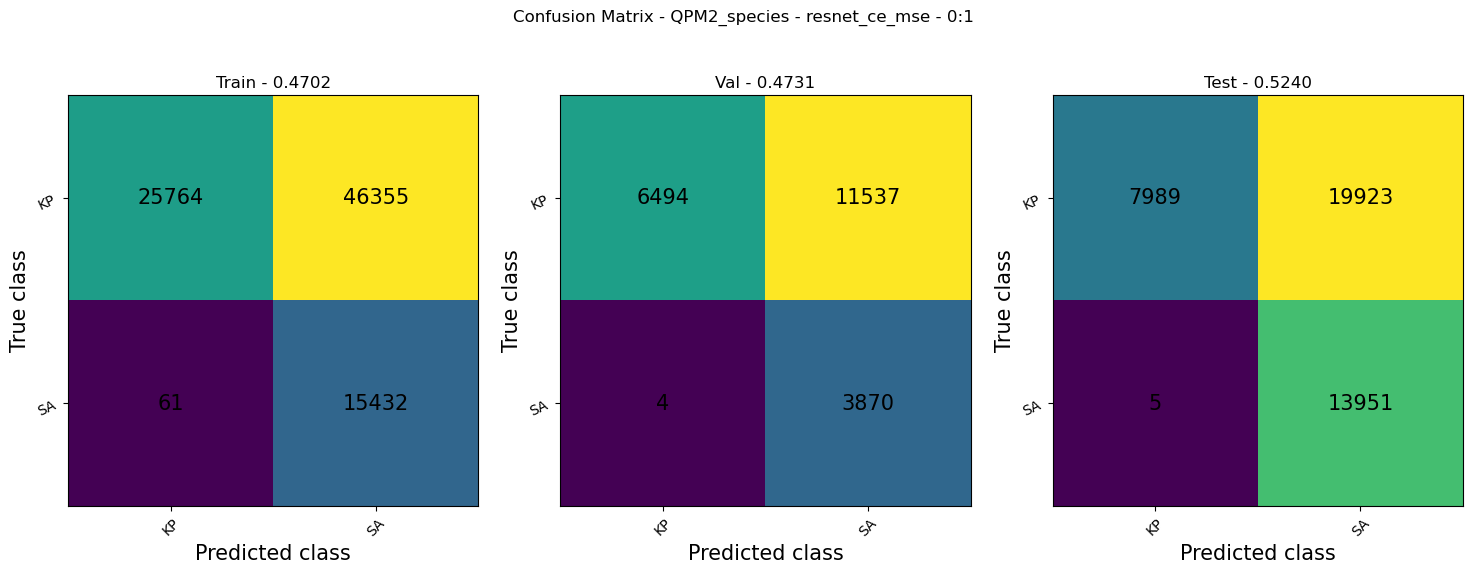

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)
(41868, 2) (55824, 2)


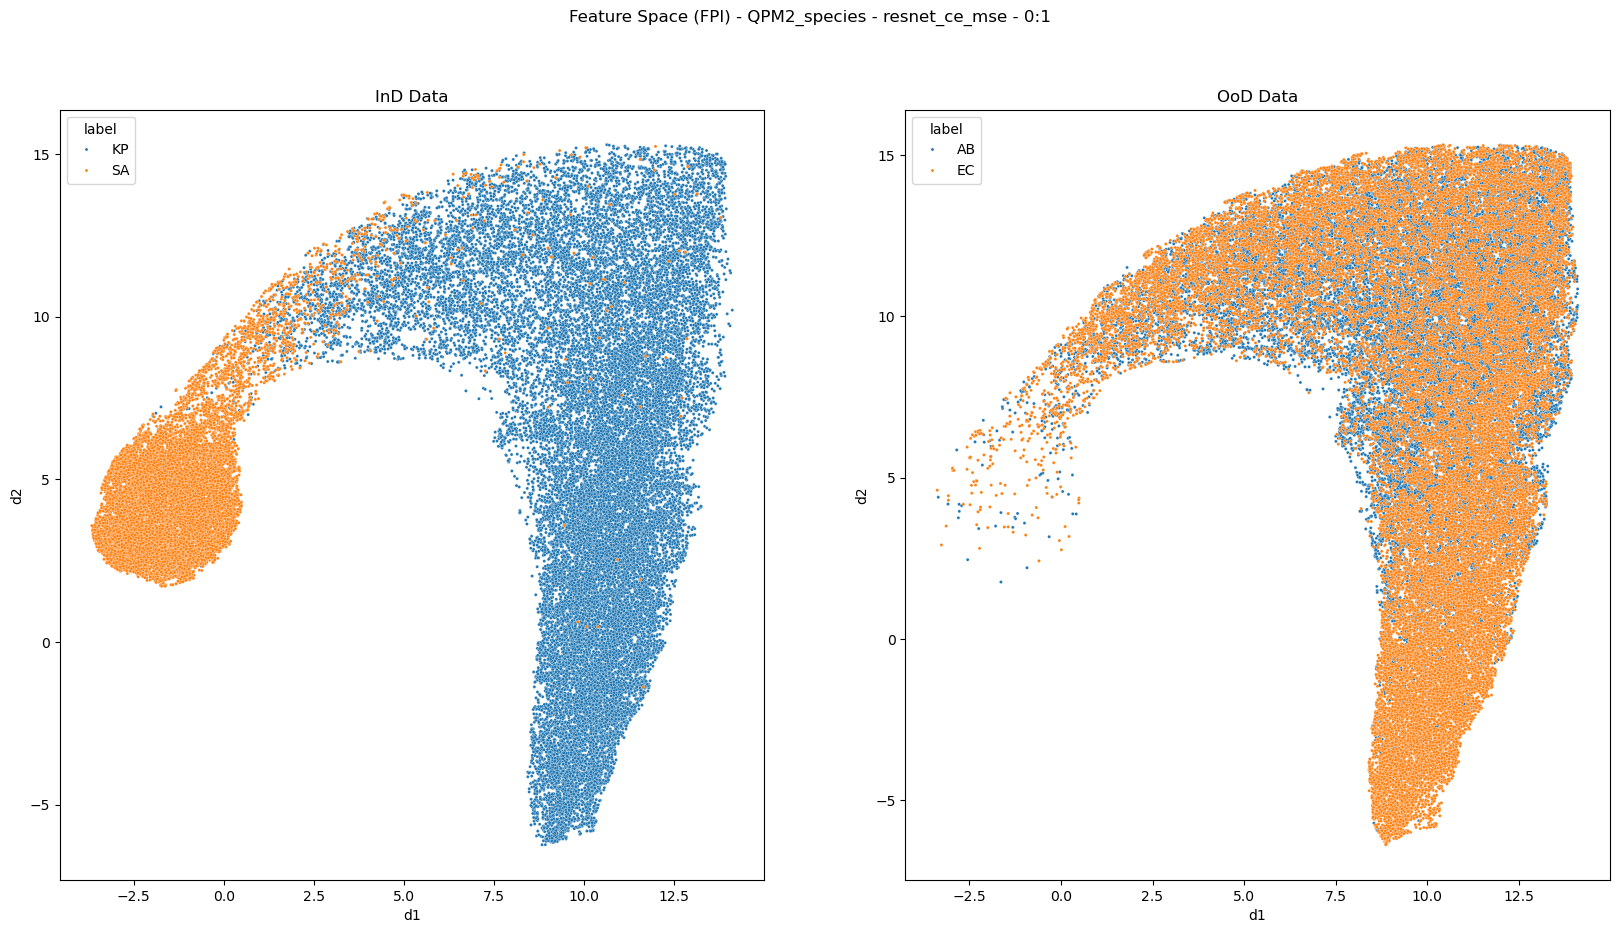

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

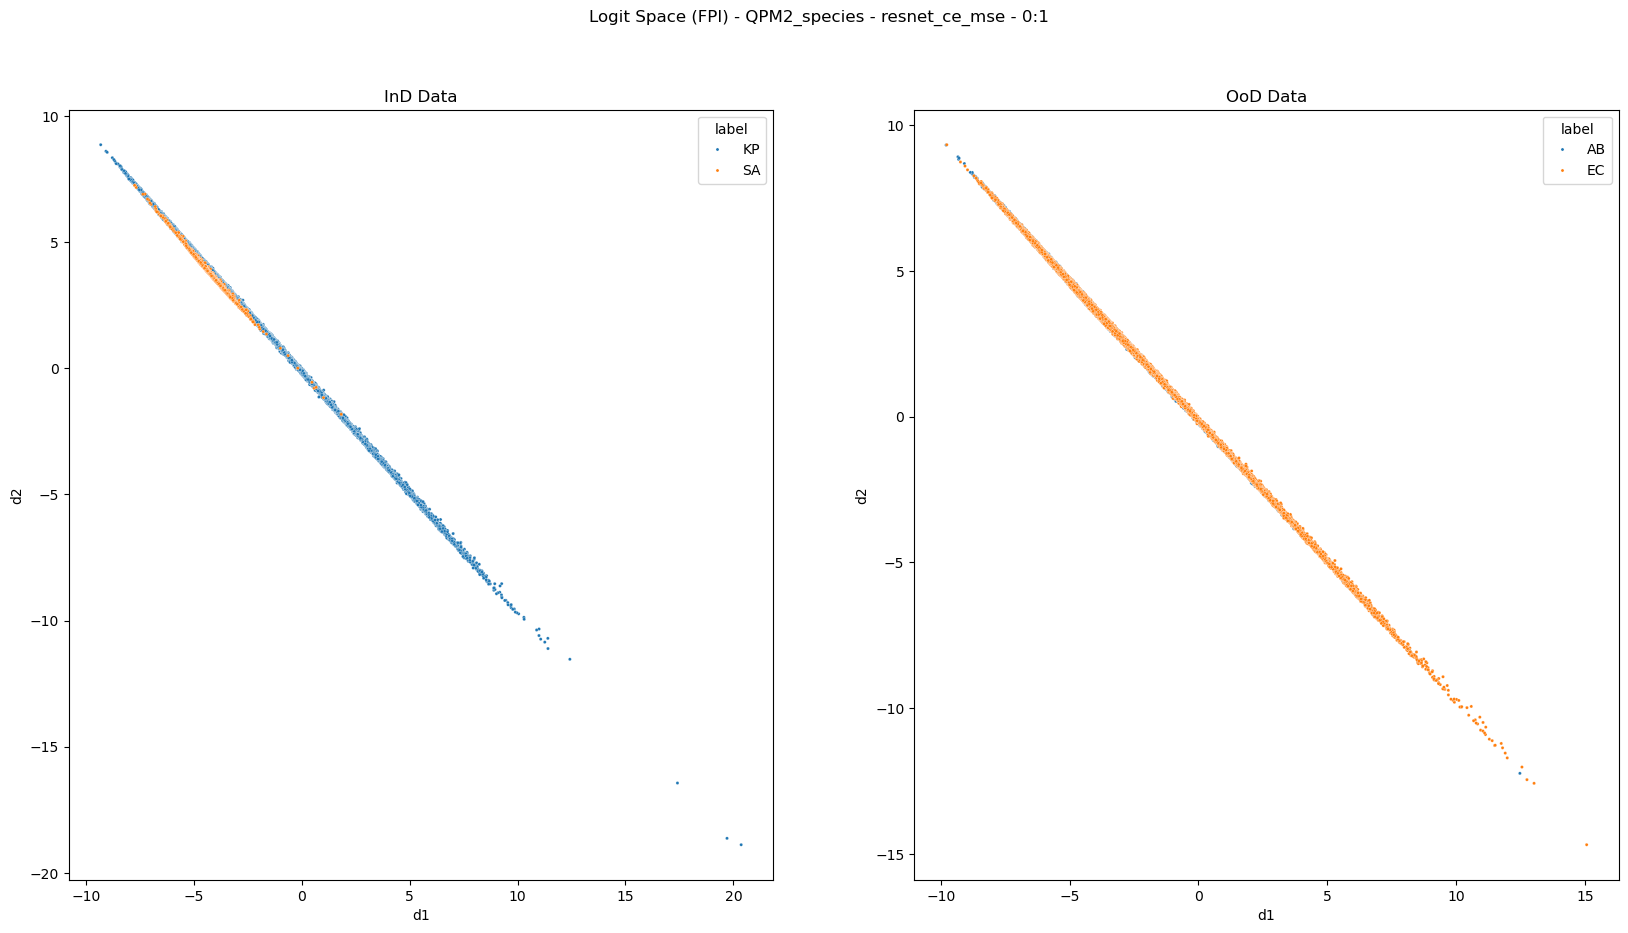

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

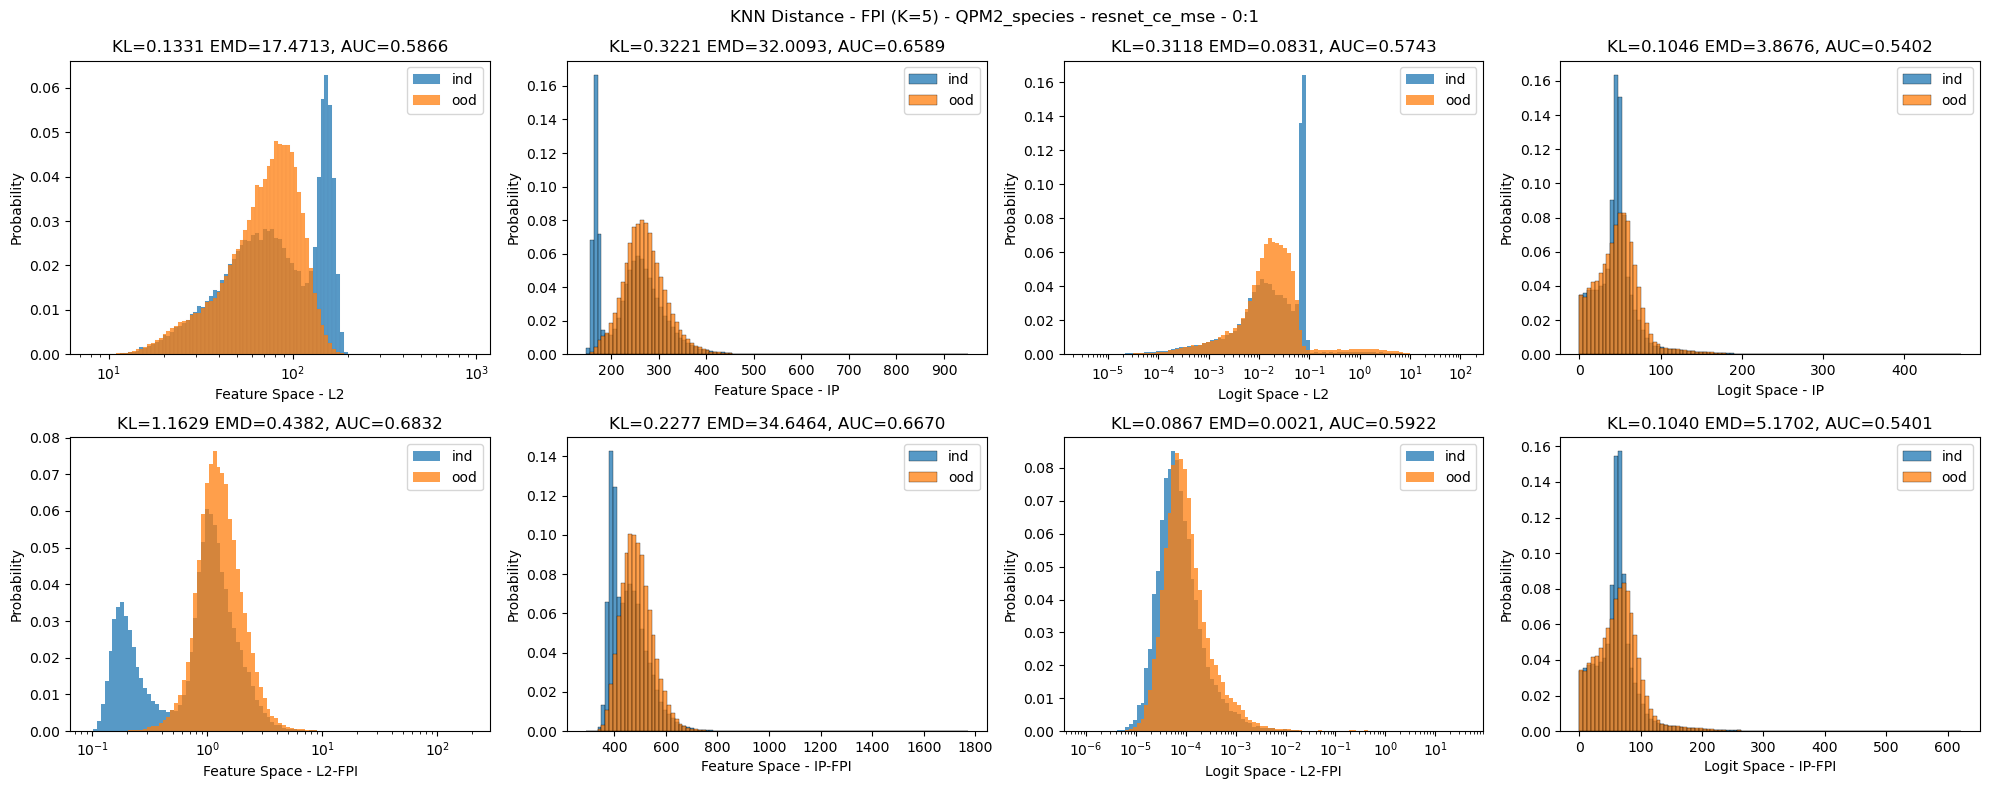

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
run_stats["knn_f_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
run_stats["knn_f_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
run_stats["knn_l_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
run_stats["knn_l_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

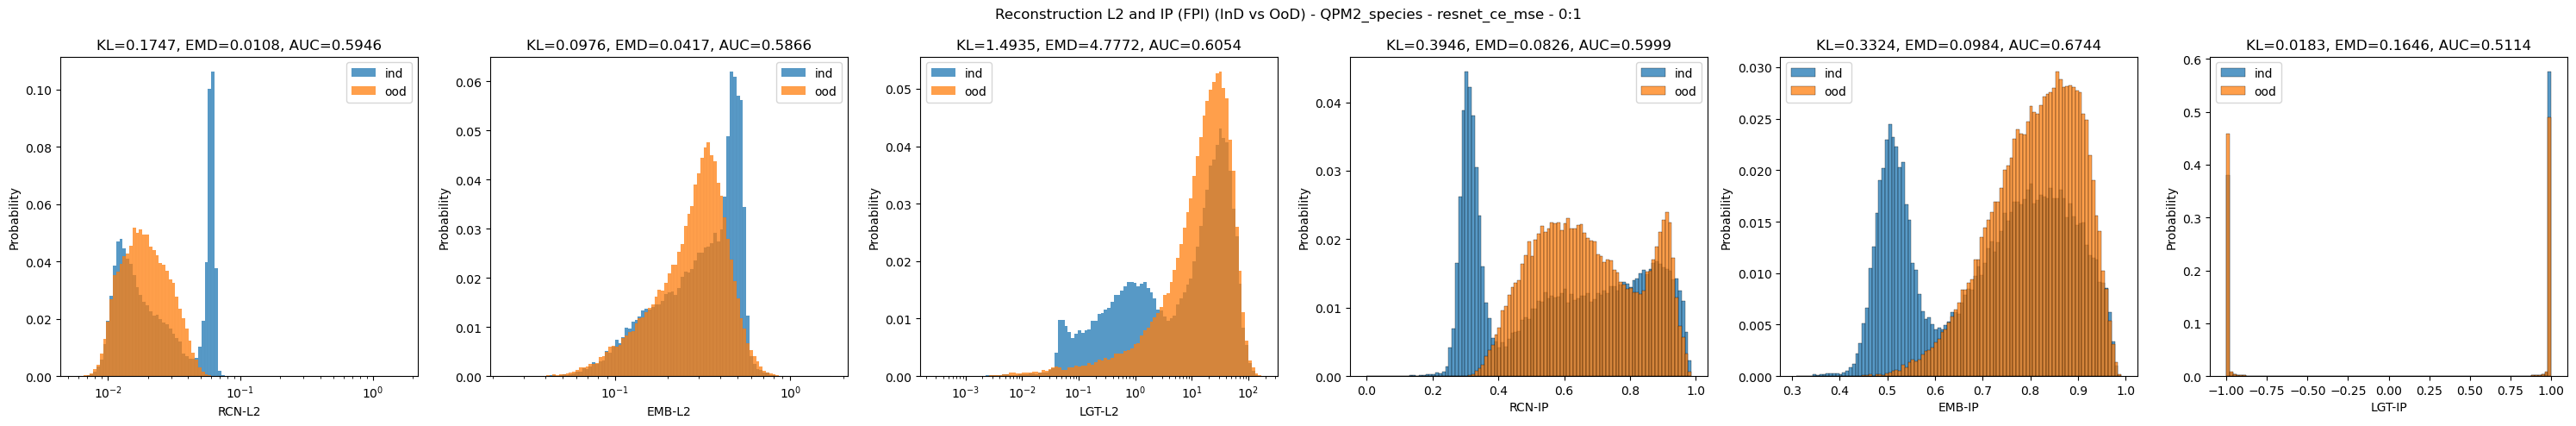

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["emb_l2"] = plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["lgt_l2"] = plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["emb_ip"] = plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["lgt_ip"] = plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

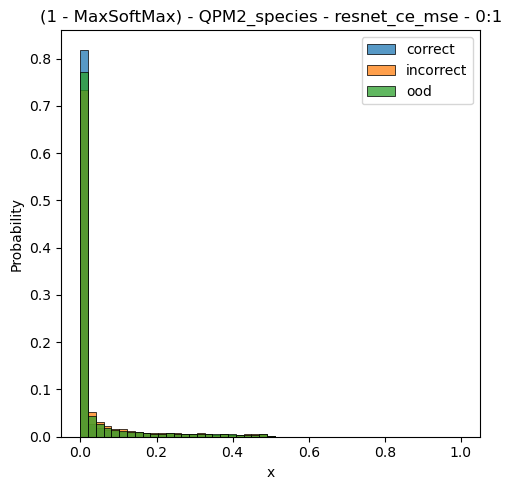

In [17]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [18]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)